In [3]:
# !kaggle competitions download -c advanced-dls-spring-2021
# !unzip advanced-dls-spring-2021

# Exploratory data analysis EDA

Мы пытаемся научить модель предсказывать уйдет клиент или нет, ведь если мы знаем, что клиент собирается уйти от нас, то мы попытаться удержать его, предложив какие-то бонусы. Эта задача очень важна на практике и алгоритмы для ее решения используются в реальных телеком компаниях.
Имеем два файла - Train_X.csv (содержит колонки признаков и целевую переменную) и test.csv (содержит только колонки признаков). В качестве ответа необходимо загрузить предсказания вероятностей ухода клиентов для test.csv. Пример файла с предскзааниями - submission.csv.
Оценка качества предсказания модели будет по метрике ROC-AUC.

### 1. Importing the required libraries for EDA

In [ ]:
import os
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import json
import joblib
import optuna
import numpy as np
import seaborn as sns
import tqdm as notebook_tqdm
from pathlib import Path
from matplotlib.lines import Line2D
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV, 
    StratifiedKFold
    )
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.random_projection import SparseRandomProjection
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    make_scorer,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    RocCurveDisplay,
    precision_recall_curve,
    recall_score,
    precision_score,
    f1_score,
    fbeta_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
from imblearn.under_sampling import (
    TomekLinks, EditedNearestNeighbours, 
    OneSidedSelection, RepeatedEditedNearestNeighbours,
    NeighbourhoodCleaningRule, InstanceHardnessThreshold
)
from imblearn.over_sampling import (
    SMOTE, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, ADASYN
)
from imblearn.combine import SMOTEENN
from collections import Counter
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
from multipledispatch import dispatch
from catboost import CatBoostClassifier


C:\Users\medvedev.r\Desktop\PredictingUserChurn\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [133]:
# --- пути для сохранений ---
CONFIGS_DIR = Path("./configs")
MODELS_DIR = Path("./models") 
os.makedirs(CONFIGS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

### 2. Loading the data into the data frame and checking the types of data¶

In [134]:
# Loading Train DataFrame
df = pl.read_csv(
    "./data/train.csv",
    separator=",",
    has_header=True
)

In [135]:
df.head()

ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
i64,f64,f64,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64
55,19.5,1026.35,"""Male""",0,"""Yes""","""Yes""","""Yes""","""No""","""No""","""No internet service""","""No internet service""","""No internet service""","""No internet service""","""No internet service""","""No internet service""","""One year""","""No""","""Mailed check""",0
72,25.85,1872.2,"""Male""",0,"""Yes""","""No""","""Yes""","""Yes""","""No""","""No internet service""","""No internet service""","""No internet service""","""No internet service""","""No internet service""","""No internet service""","""Two year""","""No""","""Credit card (automatic)""",0
1,75.9,75.9,"""Male""",0,"""No""","""No""","""Yes""","""No""","""Fiber optic""","""No""","""No""","""No""","""Yes""","""No""","""No""","""Month-to-month""","""Yes""","""Electronic check""",1
32,79.3,2570.0,"""Female""",1,"""Yes""","""No""","""Yes""","""Yes""","""Fiber optic""","""No""","""No""","""Yes""","""No""","""No""","""No""","""Month-to-month""","""No""","""Mailed check""",0
60,115.25,6758.45,"""Female""",0,"""Yes""","""Yes""","""Yes""","""Yes""","""Fiber optic""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""Two year""","""No""","""Credit card (automatic)""",0


In [136]:
# Loading Test DataFrame
Test = pl.read_csv(
    "./data/test.csv",
    separator=",",
    has_header=True
)

Отбор признаков по типу

In [137]:
numerical = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

categorical = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

In [138]:
class FeatureManager:
    def __init__(self, num: list = None, cat: list = None, target: str = None):
        self.numerical = num
        self.categorical = cat
        self.target = target

    def numerical_idx(self, data):
        """Вернет индексы числовых признаков."""
        return [data.get_column_index(name) for name in self.numerical]

    def categorical_idx(self, data):
        """Вернет индексы категориальных признаков."""
        return [data.get_column_index(name) for name in self.categorical]

    @property
    def X(self):
        """Вернет наименования признаков."""
        return self.numerical + self.categorical

    @property
    def Y(self):
        """Вернет наименование целевой переменной."""
        return self.target

    
    @dispatch(str)
    def remove(self, col):
        """Удаляет один признак из соответствующих списков.
        
        Параметры:
            col (str): Название признака для удаления
        Пример:
            manager.remove('age')
        """
        try:
            if col in self.categorical:
                self.categorical.remove(col)
            else:
                self.numerical.remove(col)
        except ValueError as e:
            raise ValueError(f"FeatureManager не содержит {col} признак!") from e

            
    @dispatch(list)
    def remove(self, cols):
        """Удаляет несколько признаков из списков.
        
        Параметры:
            cols (list): Список названий признаков
            
        Пример:
            manager.remove(['age', 'gender'])
        """
        for col in cols:
            try:
                if col in self.categorical:
                    self.categorical.remove(col)
                else:
                    self.numerical.remove(col)
            except ValueError as e:
                raise ValueError(f"FeatureManager не содержит {col} признак!") from e

In [139]:
feature = FeatureManager(numerical, categorical, 'Churn')

### 3. Dropping the duplicate rows

In [140]:
print(f"Исходный размер даннных {df.shape[0]} записей")

Исходный размер даннных 5282 записей


In [141]:
print(f"В тренировочном наборе {df.filter(df.is_duplicated()).shape[0]} записей продублированы!")

В тренировочном наборе 28 записей продублированы!


Дублирующихся значений не много, удалим их.

In [142]:
df = df.unique()

In [143]:
df.shape[0]

5268

### 4. Gaps

In [144]:
print(df.null_count().unpivot().filter(pl.col("value")!=0))

shape: (1, 2)
┌────────────┬───────┐
│ variable   ┆ value │
│ ---        ┆ ---   │
│ str        ┆ u32   │
╞════════════╪═══════╡
│ TotalSpent ┆ 9     │
└────────────┴───────┘


In [145]:
df.filter(pl.any_horizontal(pl.all().is_null()))

ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
i64,f64,f64,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64
0,25.75,null,"""Male""",0,"""Yes""","""Yes""","""Yes""","""Yes""","""No""","""No internet service""","""No internet service""","""No internet service""","""No internet service""","""No internet service""","""No internet service""","""Two year""","""No""","""Mailed check""",0
0,80.85,null,"""Female""",0,"""Yes""","""Yes""","""Yes""","""No""","""DSL""","""Yes""","""Yes""","""Yes""","""No""","""Yes""","""Yes""","""Two year""","""No""","""Mailed check""",0
0,25.35,null,"""Male""",0,"""Yes""","""Yes""","""Yes""","""Yes""","""No""","""No internet service""","""No internet service""","""No internet service""","""No internet service""","""No internet service""","""No internet service""","""Two year""","""No""","""Mailed check""",0
0,56.05,null,"""Female""",0,"""Yes""","""Yes""","""No""","""No phone service""","""DSL""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""No""","""Two year""","""No""","""Credit card (automatic)""",0
0,20.0,null,"""Female""",0,"""Yes""","""Yes""","""Yes""","""No""","""No""","""No internet service""","""No internet service""","""No internet service""","""No internet service""","""No internet service""","""No internet service""","""Two year""","""No""","""Mailed check""",0
0,52.55,null,"""Female""",0,"""Yes""","""Yes""","""No""","""No phone service""","""DSL""","""Yes""","""No""","""Yes""","""Yes""","""Yes""","""No""","""Two year""","""Yes""","""Bank transfer (automatic)""",0
0,73.35,null,"""Female""",0,"""Yes""","""Yes""","""Yes""","""Yes""","""DSL""","""No""","""Yes""","""Yes""","""Yes""","""Yes""","""No""","""Two year""","""No""","""Mailed check""",0
0,19.7,null,"""Male""",0,"""Yes""","""Yes""","""Yes""","""No""","""No""","""No internet service""","""No internet service""","""No internet service""","""No internet service""","""No internet service""","""No internet service""","""One year""","""Yes""","""Mailed check""",0
0,61.9,null,"""Male""",0,"""No""","""Yes""","""Yes""","""Yes""","""DSL""","""Yes""","""Yes""","""No""","""Yes""","""No""","""No""","""Two year""","""Yes""","""Bank transfer (automatic)""",0


Пропусков не много, можно удалить, а можно заменить значениями из MonthlySpending т.к. период у клиента = 0

In [146]:
# df = df.drop_nulls()

df = df.with_columns(
    pl.col('TotalSpent').fill_null(pl.col('MonthlySpending'))
)

#### 5.1 Categorical features

In [147]:
def show_value_counts(df: pl.DataFrame, columns: list[str]) -> None:
    """
    Выводит частотные таблицы (value_counts) для указанных колонок.
    
    Параметры:
        df: DataFrame Polars.
        columns: Список колонок для анализа.
    """
    for col in columns:
        if col not in df.columns:
            print(f"Колонка '{col}' не найдена в DataFrame.")
            continue
        
        print(f"\n Распределение значений в колонке '{col}':")
        print(df[col].value_counts(sort=True))  # Сортировка по убыванию частот

In [148]:
show_value_counts(df, categorical)


 Распределение значений в колонке 'Sex':
shape: (2, 2)
┌────────┬───────┐
│ Sex    ┆ count │
│ ---    ┆ ---   │
│ str    ┆ u32   │
╞════════╪═══════╡
│ Male   ┆ 2647  │
│ Female ┆ 2621  │
└────────┴───────┘

 Распределение значений в колонке 'IsSeniorCitizen':
shape: (2, 2)
┌─────────────────┬───────┐
│ IsSeniorCitizen ┆ count │
│ ---             ┆ ---   │
│ i64             ┆ u32   │
╞═════════════════╪═══════╡
│ 0               ┆ 4427  │
│ 1               ┆ 841   │
└─────────────────┴───────┘

 Распределение значений в колонке 'HasPartner':
shape: (2, 2)
┌────────────┬───────┐
│ HasPartner ┆ count │
│ ---        ┆ ---   │
│ str        ┆ u32   │
╞════════════╪═══════╡
│ No         ┆ 2691  │
│ Yes        ┆ 2577  │
└────────────┴───────┘

 Распределение значений в колонке 'HasChild':
shape: (2, 2)
┌──────────┬───────┐
│ HasChild ┆ count │
│ ---      ┆ ---   │
│ str      ┆ u32   │
╞══════════╪═══════╡
│ No       ┆ 3662  │
│ Yes      ┆ 1606  │
└──────────┴───────┘

 Распределение значений

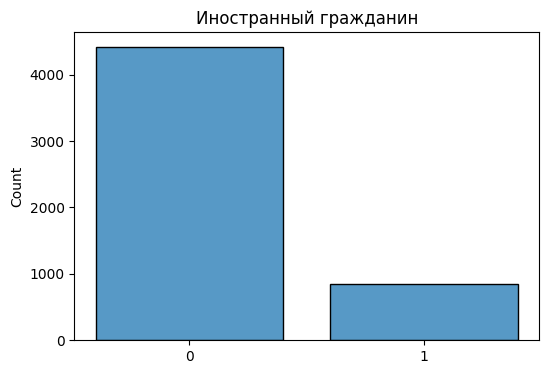

In [22]:
plt.figure(figsize=(6, 4))
sns.histplot(data=df['IsSeniorCitizen'].cast(pl.String), discrete=True, shrink=0.8)

plt.title('Иностранный гражданин')
plt.show()

In [23]:
NotSeniorCitizen = df.filter(pl.col(['IsSeniorCitizen']) == 0).shape[0]
IsSeniorCitizen = df.filter(pl.col(['IsSeniorCitizen']) == 1).shape[0]
SeniorCitizenRatio = 100/(NotSeniorCitizen+IsSeniorCitizen)*IsSeniorCitizen
print("Процент иностранных граждан {:.2f} %".format(SeniorCitizenRatio))

Процент иностранных граждан 15.99 %


In [24]:
# Добавим столбец на удаление
# feature.remove('IsSeniorCitizen')


---

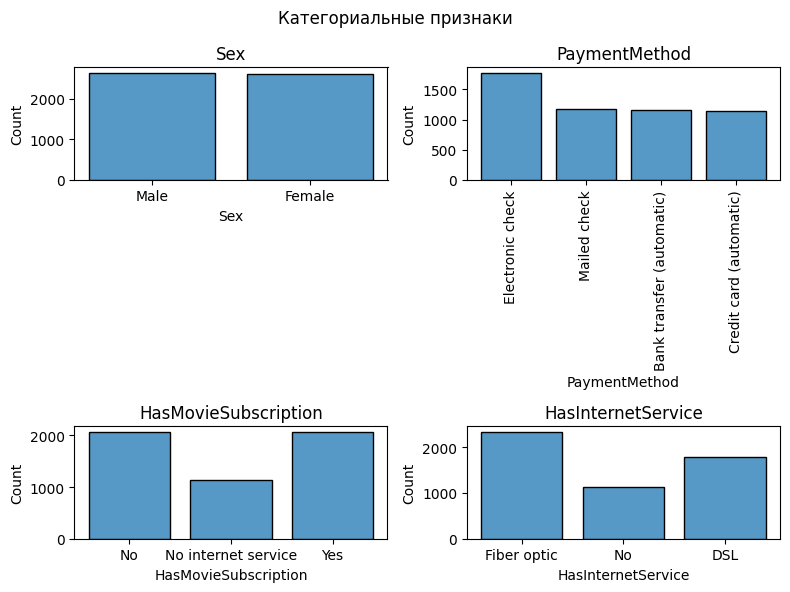

In [ ]:
# Создаем сетку графиков 2x2
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
fig.suptitle('Категориальные признаки')

# График 1:
sns.histplot(data=df[categorical], x='Sex', discrete=True, shrink=0.8, ax=axes[0, 0])
axes[0, 0].set_title('Sex')

# График 2:
sns.histplot(data=df[categorical], x='PaymentMethod', discrete=True, shrink=0.8, ax=axes[0, 1])
axes[0, 1].set_title('PaymentMethod')
axes[0, 1].tick_params(axis='x', rotation=90)

# График 3:
sns.histplot(data=df[categorical], x='HasMovieSubscription', discrete=True, shrink=0.8, ax=axes[1, 0])
axes[1, 0].set_title('HasMovieSubscription')

# График 4:
sns.histplot(data=df[categorical], x='HasInternetService', discrete=True, shrink=0.8, ax=axes[1, 1])
axes[1, 1].set_title('HasInternetService')

plt.tight_layout()
plt.show()

#### 5.2 Quantitative features

In [149]:
df[numerical].describe()

statistic,ClientPeriod,MonthlySpending,TotalSpent
str,f64,f64,f64
"""count""",5268.0,5268.0,5268.0
"""null_count""",0.0,0.0,0.0
"""mean""",32.480448,64.977563,2293.524421
"""std""",24.529439,30.176025,2269.032651
"""min""",0.0,18.25,18.8
"""25%""",9.0,35.55,401.95
"""50%""",29.0,70.45,1411.65
"""75%""",55.0,90.05,3808.0
"""max""",72.0,118.75,8684.8


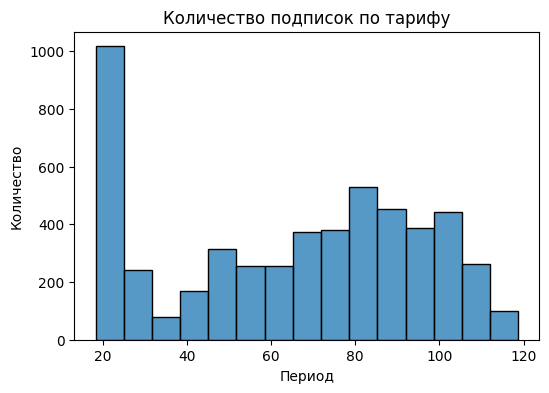

In [27]:
# Строим гистограмму 

plt.figure(figsize=(6, 4))

sns.histplot(df['MonthlySpending'], bins=15)

plt.title('Количество подписок по тарифу')
plt.xlabel('Период')
plt.ylabel('Количество')

plt.show()

Самая популярная подписка за 20$

In [28]:
# Среднее значение трат по периодам
mean_spending = df.group_by("ClientPeriod").agg(
    pl.col("MonthlySpending").mean().alias("avg_spending")
).sort("ClientPeriod")  # сортировка по группам

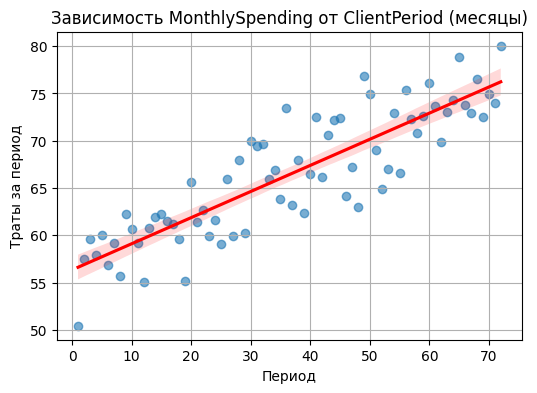

In [29]:
plt.figure(figsize=(6, 4))
sns.regplot(
    data=mean_spending,
    x="ClientPeriod",
    y="avg_spending",
    scatter_kws={"alpha": 0.6},
    line_kws={"color": "red"}
)
plt.title("Зависимость MonthlySpending от ClientPeriod (месяцы)")
plt.xlabel("Период")
plt.ylabel("Траты за период")
plt.grid()
plt.show()

Смотрим среднее распределение за каждый период. Видим линенйную зависимость, трат клиентов от периода. Клиенты с увеличение периода платили больше.

In [30]:
# Группируем периоды
GROUP = 12
df = df.with_columns((pl.col("ClientPeriod") // GROUP * GROUP).alias("PeriodGroup"))

In [31]:
# Посчитываем количество клиентов
# Рассчитываем кумулятивнную суммы
df_cumulative = df.group_by("PeriodGroup")\
    .agg(pl.len().alias("ClientsCount"))\
    .sort("PeriodGroup", descending = True)\
    .with_columns(pl.col("ClientsCount").cum_sum().alias("CumulativeClients"))

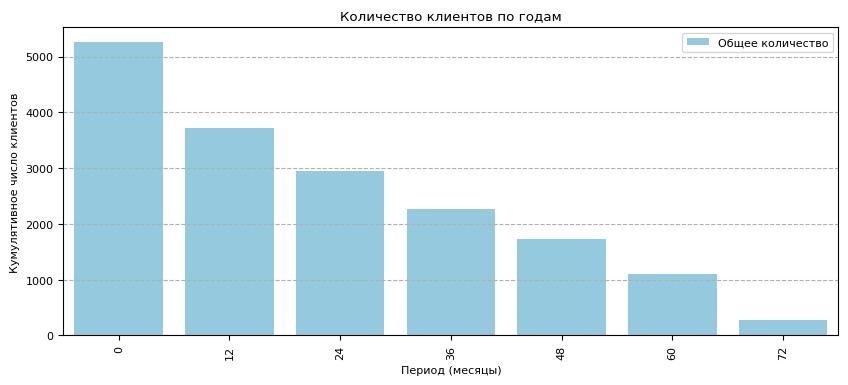

In [32]:
plt.rcParams.update({'font.size': 8})

# График
plt.figure(figsize=(10, 4))

ax = sns.barplot(
    data=df_cumulative,
    x="PeriodGroup",
    y="CumulativeClients",
    color="skyblue",
    label="Общее количество"
)


plt.title("Количество клиентов по годам")
plt.xlabel("Период (месяцы)")
plt.ylabel("Кумулятивное число клиентов")
plt.grid(axis="y", linestyle="--")
plt.xticks(rotation=90)
plt.show()

В первый год было более 5000 клиентов, в последующие года происходит отток клиенетов. Нисходящий тркенд.

In [33]:
df_TotalSpent = df.group_by("PeriodGroup").agg(
        pl.col("TotalSpent").sum()).sort("PeriodGroup")

In [34]:
# Посчитываем количество клиентов
# Рассчитываем кумулятивнную суммы
df_CumulativeTotalSpent = df.with_columns((pl.col("TotalSpent") / pl.col("ClientPeriod") ).alias("SpentByPeriod"))\
    .group_by("PeriodGroup")\
    .agg(pl.col("SpentByPeriod").sum())\
    .sort("PeriodGroup", descending = True)\
    .with_columns(pl.col("SpentByPeriod").cum_sum().alias("CumulativeTotalSpent"))

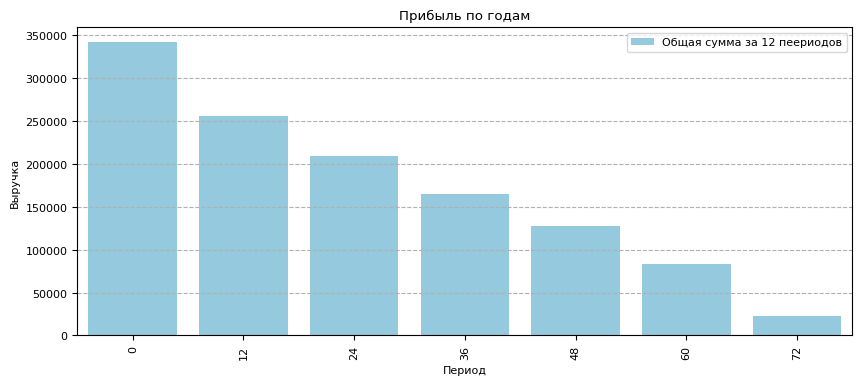

In [35]:
plt.rcParams.update({'font.size': 8})

# График
plt.figure(figsize=(10, 4))

ax = sns.barplot(
    data=df_CumulativeTotalSpent,
    x="PeriodGroup",
    y="CumulativeTotalSpent",
    color="skyblue",
    label = f"Общая сумма за {GROUP} пеериодов"
)

plt.title("Прибыль по годам")
plt.xlabel("Период")
plt.ylabel("Выручка")
plt.grid(axis="y", linestyle="--")
plt.xticks(rotation=90)
plt.show()

При оттоке клиентов ожидаемо падает прибыль

In [36]:
df_MonthlySpending = df.group_by("PeriodGroup")\
    .agg(pl.col("MonthlySpending").mean()).sort("PeriodGroup")

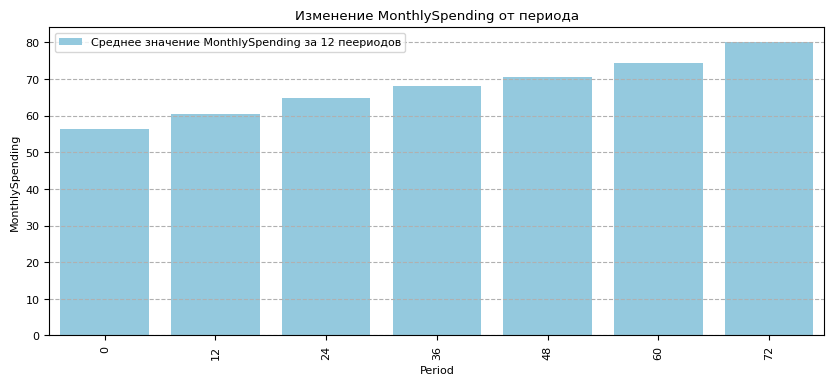

In [37]:
# График
plt.figure(figsize=(10, 4))

ax = sns.barplot(
    data=df_MonthlySpending,
    x="PeriodGroup",
    y="MonthlySpending",
    color="skyblue",
    label = f"Среднее значение MonthlySpending за {GROUP} пеериодов"
)


plt.title("Изменение MonthlySpending от периода")
plt.xlabel("Period")
plt.ylabel("MonthlySpending")
plt.grid(axis="y", linestyle="--")
plt.xticks(rotation=90)
plt.show()

Наблюдаем тенденцию изменения стоимоти подписки за один год.

#### 5.3 Correlation matrix

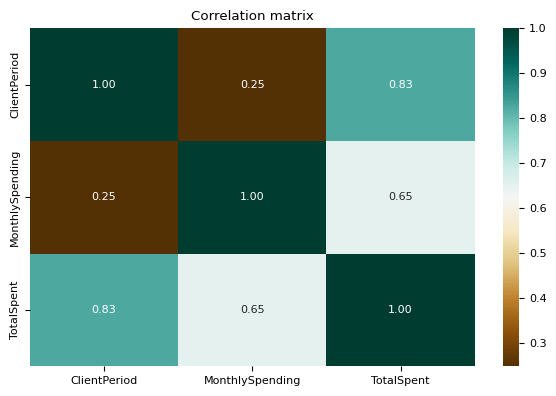

In [38]:
plt.figure(figsize=(6, 4))

corr_matrix = df[numerical].to_pandas().corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="BrBG")

plt.title('Correlation matrix')
plt.tight_layout()  # Автонастройка отступов
plt.show()

У нас два похожих признака MonthlySpending и TotalSpen. TotalSpent коррелирует с MonthlySpending и ClientPeriod т.к.
TotalSpent это сумма по периодам MonthlySpending. Уберем его из нашших данных.

In [16]:
feature.remove("TotalSpent")

### 6. Dropping irrelevant columns

Удалим не релевантные признаки, которые будут вносить шум. 

In [40]:
# feature.remove(
#     ['HasOnlineBackup','HasOnlineSecurityService','HasDeviceProtection',
#     'HasMultiplePhoneNumbers', 'HasContractPhone', 'IsBillingPaperless']
# )

### 7. Analyzing the dependence of the target on features

Распределение целевой переменной

In [41]:
df_Churn = df.group_by(["PeriodGroup", "Churn"])\
    .agg(pl.col("Churn").len().alias("ClientsCount"))\
    .sort("PeriodGroup")

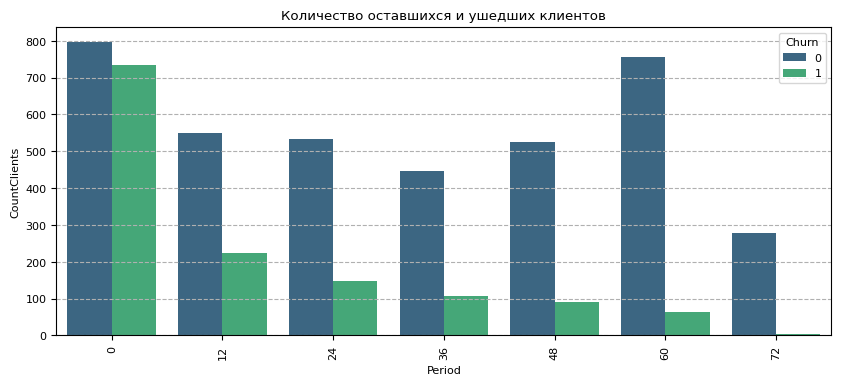

In [42]:
# График
plt.figure(figsize=(10, 4))

ax = sns.barplot(
    data=df_Churn,
    x='PeriodGroup',
    y='ClientsCount',
    hue='Churn',
    palette='viridis'
)

plt.title("Количество оставшихся и ушедших клиентов")
plt.xlabel("Period")
plt.ylabel("CountClients")
plt.grid(axis="y", linestyle="--")
plt.xticks(rotation=90)
plt.show()

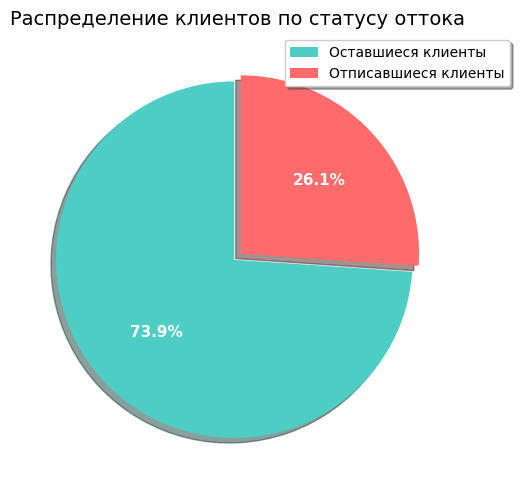

In [181]:
plt.figure(figsize=(5, 5))

df_churn_count = df.group_by('Churn').len()

# Цветовая схема
colors = ['#4ecdc4', '#ff6b6b']  # Зеленый для остающихся, красный для ушедших
explode = (0, 0.05)  # Немного выдвигаем сектор "Отписавшиеся"

# Создаем круговую диаграмму
wedges, texts, autotexts = plt.pie(df_churn_count['len'], 
                                   colors=colors,
                                   explode=explode,
                                   autopct='%1.1f%%',
                                   startangle=90,
                                   shadow=True,
                                   textprops={'fontsize': 12})

# Улучшаем проценты
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

# Заголовок
plt.title('Распределение клиентов по статусу оттока', 
          fontsize=14)

# Легенда
plt.legend(["Оставшиеся клиенты", "Отписавшиеся клиенты"],
           loc='upper right',
           bbox_to_anchor=(1.2, 1.),
           frameon=True,
           fancybox=True,
           shadow=True)

# Делаем диаграмму круглой
plt.axis('equal')

plt.tight_layout()
plt.show()

На круговой диаграмме виден дисбаланс класов. 

#### 7.1 Box plot for quantitative features

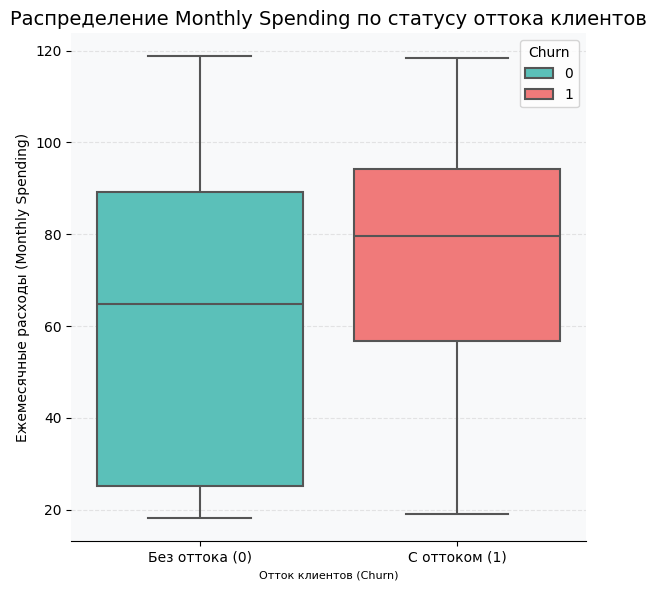

In [ ]:
plt.figure(figsize=(6, 6))

# Для числовых значений 0 и 1
boxplot = sns.boxplot(data=df.to_pandas(), y="MonthlySpending", x="Churn",  hue="Churn", whis=1.5,
                      palette=['#4ecdc4', '#ff6b6b'], 
                      linewidth=1.5, saturation=0.8)

plt.title("Распределение Monthly Spending по статусу оттока клиентов", 
          fontsize=14)
plt.xlabel("Отток клиентов (Churn)", fontsize=8)
plt.ylabel("Ежемесячные расходы (Monthly Spending)", fontsize=10)

# Обновляем подписи по оси X
plt.xticks(ticks=[0, 1], labels=['Без оттока (0)', 'С оттоком (1)'])

plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.gca().set_facecolor('#f8f9fa')
sns.despine(left=True)
plt.tight_layout()

plt.show();

#### 7.2 Categorical features

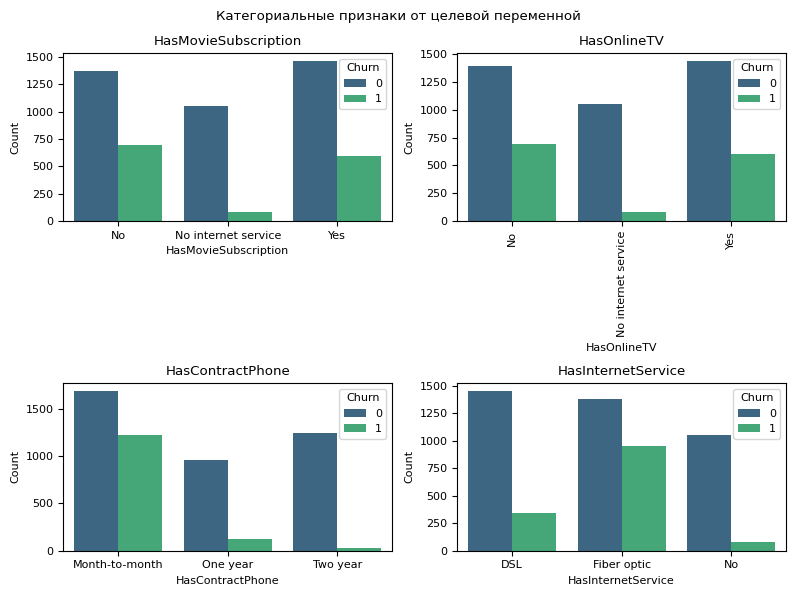

In [45]:
# Создаем сетку графиков 2x2
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
fig.suptitle('Категориальные признаки от целевой переменной')

# График 1:
ax = sns.barplot(
    data=df.group_by(["Churn", "HasMovieSubscription"])\
    .agg(pl.col("Churn").len().alias("Count"))\
    .sort("HasMovieSubscription"),
    x='HasMovieSubscription',
    y='Count',
    hue='Churn',
    palette='viridis',
    ax=axes[0, 0] 
)
axes[0, 0].set_title('HasMovieSubscription')

# График 2:
ax = sns.barplot(
    data=df.group_by(["Churn", "HasOnlineTV"])\
    .agg(pl.col("Churn").len().alias("Count"))\
    .sort("HasOnlineTV"),
    x='HasOnlineTV',
    y='Count',
    hue='Churn',
    palette='viridis',
    ax=axes[0, 1] 
)
axes[0, 1].set_title('HasOnlineTV')
axes[0, 1].tick_params(axis='x', rotation=90)

# График 3:
ax = sns.barplot(
    data=df.group_by(["Churn", "HasContractPhone"])\
    .agg(pl.col("Churn").len().alias("Count"))\
    .sort("HasContractPhone"),
    x='HasContractPhone',
    y='Count',
    hue='Churn',
    palette='viridis',
    ax=axes[1, 0] 
)
axes[1, 0].set_title('HasContractPhone')

# График 4:
ax = sns.barplot(
    data=df.group_by(["Churn", "HasInternetService"])\
    .agg(pl.col("Churn").len().alias("Count"))\
    .sort("HasInternetService"),
    x='HasInternetService',
    y='Count',
    hue='Churn',
    palette='viridis',
    ax=axes[1, 1] 
)
axes[1, 1].set_title('HasInternetService')

plt.tight_layout()
plt.show()

#### 7.3 Replace value

In [17]:
columns_to_replace = [
    'HasTechSupportAccess',
    'HasOnlineTV', 'HasMovieSubscription'
]

# Заменяем "No internet service" на "No"
Train = df.with_columns(pl.col(columns_to_replace).replace('No internet service', 'No'))


# Test = Test.with_columns(pl.col(columns_to_replace).replace('No internet service', 'No'))

In [18]:
Train[feature.X]

ClientPeriod,MonthlySpending,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
i64,f64,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str
32,19.8,"""Male""",1,"""No""","""No""","""Yes""","""No""","""No""","""No internet service""","""No internet service""","""No internet service""","""No""","""No""","""No""","""One year""","""No""","""Credit card (automatic)"""
50,70.35,"""Male""",1,"""No""","""No""","""Yes""","""Yes""","""DSL""","""Yes""","""Yes""","""No""","""No""","""Yes""","""No""","""Month-to-month""","""Yes""","""Bank transfer (automatic)"""
30,74.75,"""Male""",1,"""No""","""No""","""Yes""","""No""","""DSL""","""Yes""","""Yes""","""No""","""No""","""Yes""","""Yes""","""Month-to-month""","""Yes""","""Electronic check"""
2,70.35,"""Female""",1,"""No""","""No""","""Yes""","""No""","""Fiber optic""","""No""","""No""","""No""","""No""","""No""","""No""","""Month-to-month""","""Yes""","""Electronic check"""
1,80.0,"""Male""",0,"""Yes""","""Yes""","""Yes""","""No""","""Fiber optic""","""No""","""No""","""No""","""No""","""No""","""Yes""","""Month-to-month""","""No""","""Electronic check"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
47,74.05,"""Female""",0,"""No""","""No""","""Yes""","""Yes""","""DSL""","""Yes""","""Yes""","""No""","""Yes""","""No""","""Yes""","""Two year""","""No""","""Mailed check"""
58,20.3,"""Male""",0,"""No""","""No""","""Yes""","""No""","""No""","""No internet service""","""No internet service""","""No internet service""","""No""","""No""","""No""","""Two year""","""No""","""Credit card (automatic)"""
60,105.9,"""Female""",1,"""Yes""","""No""","""Yes""","""Yes""","""Fiber optic""","""No""","""Yes""","""Yes""","""No""","""Yes""","""Yes""","""Month-to-month""","""Yes""","""Electronic check"""


#### Split data

In [19]:
# 1. Создаем ClientPeriod_Bin через qcut
# Разбиваем на 5 интервалов с примерно равным количеством наблюдений
Train = Train.with_columns(
    pl.col("ClientPeriod").qcut(5, labels=["bin1", "bin2", "bin3", "bin4", "bin5"]).alias("ClientPeriod_Bin")
)

In [20]:
# 2. Создаем стратификационный ключ
Train = Train.with_columns(
    pl.format("churn_{}_tenure_{}", pl.col(feature.Y), pl.col("ClientPeriod_Bin")).alias("stratify_key")
)

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(
    Train[feature.X],
    Train[feature.Y],
    stratify=Train["stratify_key"],
    test_size=0.3,
    random_state=42
)

### Permutation-based feature importance

In [22]:
# Создаем трансформер для обработки данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature.numerical_idx(X_train)),  # Нормализация числовых признаков
        ('cat', OneHotEncoder(), feature.categorical_idx(X_train))  # Кодирование категориальных признаков
    ]
)

# Создаем полный пайплайн
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, min_samples_split=20, min_samples_leaf=10, random_state=42))
])

rf =  pipeline.fit(X_train.to_numpy(), y_train.to_numpy());

In [23]:
result = permutation_importance(rf, X_train.to_numpy(), y_train.to_numpy(), n_repeats=10, random_state=0, n_jobs=2)

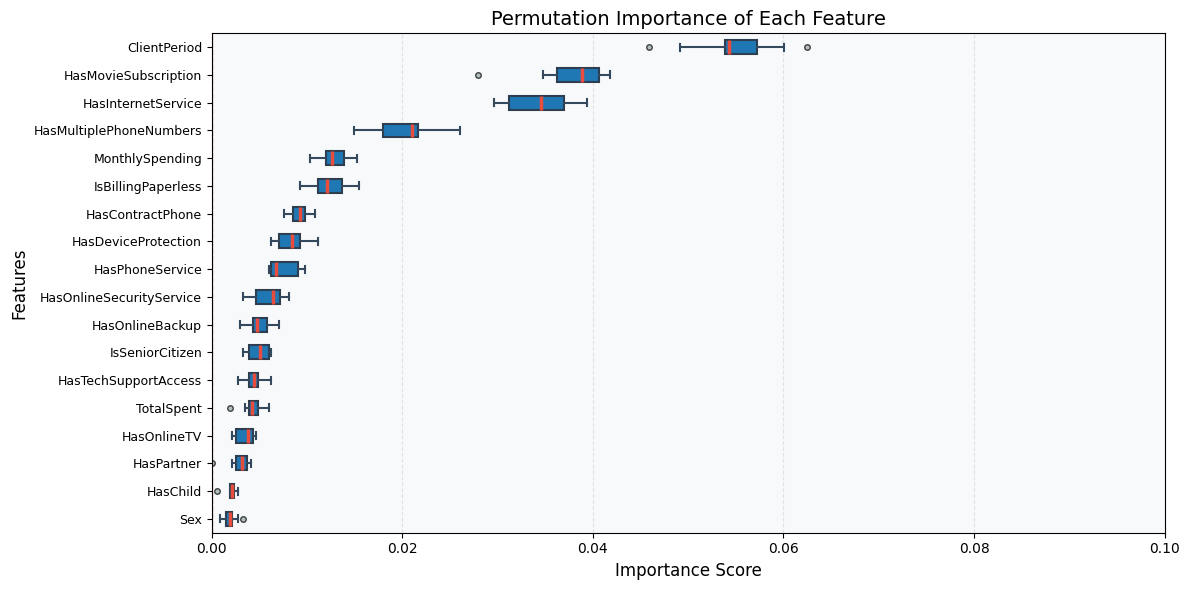

In [185]:
fig, ax = plt.subplots(figsize=(12, 6))

sorted_idx = result.importances_mean.argsort()
feature_names = np.array(feature.X)

# Создаем красивый boxplot
boxprops = dict(linestyle='-', linewidth=1.5, color='#2c3e50')
whiskerprops = dict(linestyle='-', linewidth=1.5, color='#34495e')
capprops = dict(linewidth=1.5, color='#34495e')
medianprops = dict(linestyle='-', linewidth=2.5, color='#e74c3c')
flierprops = dict(marker='o', markerfacecolor='#95a5a6', markersize=4, alpha=0.7)

ax.boxplot(result.importances[sorted_idx].T, 
           vert=False, 
           tick_labels=feature_names[sorted_idx],
           boxprops=boxprops,
           whiskerprops=whiskerprops,
           capprops=capprops,
           medianprops=medianprops,
           flierprops=flierprops,
           patch_artist=True)  # Включаем заливку

# Добавляем цветовую заливку
colors = ['#3498db' for _ in range(len(sorted_idx))]
for patch, color in zip(ax.artists, colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Настройка заголовка и осей
ax.set_title("Permutation Importance of Each Feature", 
             fontsize=14)
ax.set_xlabel("Importance Score", fontsize=12)
ax.set_ylabel("Features", fontsize=12)

# Улучшаем сетку
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Устанавливаем лимиты и улучшаем внешний вид
ax.set_xlim(0, 0.1)
ax.set_facecolor('#f8f9fa')

# Увеличиваем шрифт меток признаков
ax.tick_params(axis='y', labelsize=9)

# Добавляем вертикальную линию на нуле
ax.axvline(x=0, color='red', linestyle='--', alpha=0.5, linewidth=1)

fig.tight_layout()
plt.show()

### 8. Modeling

#### Model

In [25]:
# Создаем трансформер для обработки данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature.numerical_idx(X_train)),  # Нормализация числовых признаков
        ('cat', OneHotEncoder(), feature.categorical_idx(X_train))  # Кодирование категориальных признаков
    ]
)

# Создаем полный пайплайн
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver="saga", random_state=42))
])

In [26]:
# pipeline

In [27]:
# Стратегия кросс-валидации (стратифицируем по y, так как основную стратификацию уже сделали при создании выборки)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [28]:
param_grid = {
    'classifier__C': [100.0, 10.0, 0.1, 0.01],
    'classifier__penalty': ["l1", "l2"],
    'classifier__max_iter': [1000, 3000, 5000],
    'classifier__tol': [1e-3, 1e-2]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring=['roc_auc', 'f1', 'precision', 'recall'],
    refit='roc_auc',
    error_score='raise'
)

logreg = grid_search.fit(X_train.to_numpy(), y_train.to_numpy());

#### BaseLine

In [31]:
logreg.best_params_

{'classifier__C': 0.1,
 'classifier__max_iter': 1000,
 'classifier__penalty': 'l2',
 'classifier__tol': 0.01}

In [32]:
logreg.best_score_

np.float64(0.8414641958831783)

In [33]:
results = grid_search.cv_results_

print(f"F1: {results['mean_test_f1'][grid_search.best_index_]}")
print(f"Precision: {results['mean_test_precision'][grid_search.best_index_]}")
print(f"Recall: {results['mean_test_recall'][grid_search.best_index_]}")
print(f"AUC-ROC: {results['mean_test_roc_auc'][grid_search.best_index_]}")

F1: 0.5839892289209387
Precision: 0.6576332449210913
Recall: 0.5254749568221071
AUC-ROC: 0.8414641958831783


#### Save model

In [34]:
# --- сохранение модели ---
model_path = os.path.join(MODELS_DIR, "LogisticRegression_best.pkl")
joblib.dump(grid_search.best_estimator_, model_path)

['models\\LogisticRegression_best.pkl']

#### Roc Auc

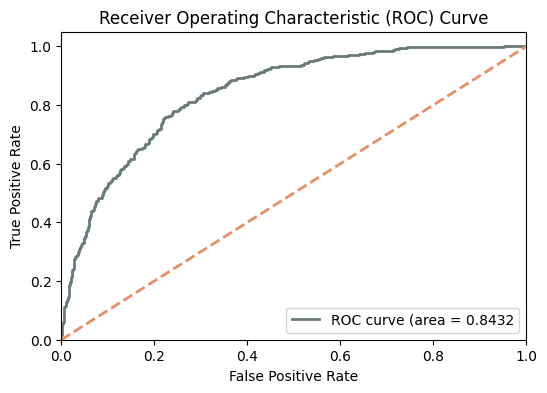

In [42]:
y_pred = logreg.predict_proba(X_valid.to_numpy())[:, 1]  # P(класс 1)

fpr, tpr, thresholds = roc_curve(y_valid, y_pred)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='#6A7B73', lw=2, label=f'ROC curve (area = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='#E78F63', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### Confusion matrix

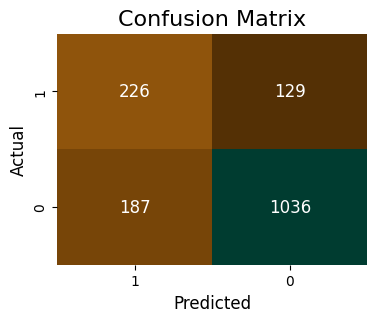

In [43]:
y_pred = (y_pred_prob_logistic >= 0.5).astype(int)

cm = confusion_matrix(y_valid, y_pred, labels=[0, 1])

TN, FP, FN, TP = cm.ravel()

fp_fn_data = pd.DataFrame({
    '1': [TP, FN],
    '0': [FP, TN]
}, index=['1', '0'])

# Построение хитмапы
plt.figure(figsize=(4, 3))
sns.heatmap(fp_fn_data, annot=True, cmap="BrBG", fmt='d', cbar=False,
            annot_kws={"size": 12})

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

#### Summary

In [44]:
print(f'TP (True Positive): {TP} \
Это количество положительных случаев, которые правильно классифицированы моделью как положительные. \
\nТо есть {TP} клиента действительно ушли (Churn = 1), и модель правильно предсказала это.')

print(f'\nFN (False Negative): {FN} \
Это количество положительных случаев, которые были ошибочно классифицированы как отрицательные. \
\nТо есть {FN} клиента, которые ушли, были неправильно предсказаны как не ушедшие (Churn = 0).')

print(f'\nFP (False Positive): {FP} \
Это количество отрицательных случаев, которые были ошибочно классифицированы как положительные. \
\nТо есть {FP} клиентов, которые не ушли, были неправильно предсказаны как ушедшие (Churn = 1).')

print(f'\nTN (True Negative): {TN} \
Это количество отрицательных случаев, которые правильно классифицированы моделью как отрицательные. \
\nТо есть {TN} клиентов действительно не ушли, и модель правильно предсказала это.')

TP (True Positive): 226 Это количество положительных случаев, которые правильно классифицированы моделью как положительные. 
То есть 226 клиента действительно ушли (Churn = 1), и модель правильно предсказала это.

FN (False Negative): 187 Это количество положительных случаев, которые были ошибочно классифицированы как отрицательные. 
То есть 187 клиента, которые ушли, были неправильно предсказаны как не ушедшие (Churn = 0).

FP (False Positive): 129 Это количество отрицательных случаев, которые были ошибочно классифицированы как положительные. 
То есть 129 клиентов, которые не ушли, были неправильно предсказаны как ушедшие (Churn = 1).

TN (True Negative): 1036 Это количество отрицательных случаев, которые правильно классифицированы моделью как отрицательные. 
То есть 1036 клиентов действительно не ушли, и модель правильно предсказала это.


Если мы поменяем threshold, то confusion matrix будет выглядеть по-другому. Таким образом, меняя threshold можно улучшить качество на несбалансированных классах, но roc-auc не поменяется, так как он измеряется по вероятностям, а не по конечным классам

### 9. Experiments

#### Functions

In [63]:
def plot_roc_auc(results: list, title: str):
    # 1. Подготовка данных
    df_results = pd.DataFrame(results)
    
    # 2. Визуализация
    plt.figure(figsize=(6, 4))
    sns.set_style("whitegrid")
    
    # Создаем комбинированную колонку для удобства отображения
    df_results['Model_Sampler'] = df_results['Model'] + ' + ' + df_results['Sampler']
    
    # Сортируем по AUC
    df_results = df_results.sort_values('ROC-AUC', ascending=False)
    
    # График
    barplot = sns.barplot(
        data=df_results,
        x='ROC-AUC',
        y='Sampler',
        hue='Model',
        palette='viridis',
        errorbar=None,
        orient='h'
    )
    
    # Настройки оформления
    plt.title(title, pad=15, fontsize=10)
    plt.xlabel('ROC-AUC', fontsize=9)
    plt.ylabel('')
    plt.xlim(0, 1.05)
    plt.grid(axis='x', alpha=0.3)
    plt.legend([], [], frameon=False)  # Скрываем стандартную легенду
    
    # Добавляем подписи для ВСЕХ столбцов
    for container in barplot.containers:
        barplot.bar_label(
            container,
            fmt='%.4f',  # Формат с 3 знаками после запятой
            label_type='edge',
            padding=5,
            fontsize=10
        )
    
    # Легенда для моделей
    model_handles = [Line2D([0], [0], color='w', marker='s', markersize=10, 
                            markerfacecolor=sns.color_palette('viridis', len(models))[i], 
                            label=model) 
                     for i, model in enumerate(df_results['Model'].unique())]
    
    first_legend = plt.legend(handles=model_handles, title='Модели', 
                              bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

In [75]:
def roc_auc_estimator(X_train, y_train, X_test, y_test, preprocessor, samplers, models):
    # Сравнение методов
    plt.figure(figsize=(5, 4))
    
    results = []
    for model_name, model in models.items():
        for sampler_name, sampler in samplers.items():

            if isinstance(sampler, tuple):
                over, under = sampler
                # Создаем pipeline
                pipeline = ImbPipeline([
                    ('preprocessor', preprocessor),
                    ('oversampler', over),
                    ('undersampler', under),
                    ('classifier', model)
                ])
            else:   
                # Создаем pipeline
                pipeline = ImbPipeline([
                            ('preprocessor', preprocessor),
                            ('sampler', sampler),
                            ('classifier', model)
                        ])
            
            # Обучение
            pipeline.fit(X_train, y_train)
            
            # Предсказание вероятностей
            if hasattr(pipeline.named_steps['classifier'], 'predict_proba'):
                y_proba = pipeline.predict_proba(X_test)[:, 1]
            else:
                y_proba = pipeline.decision_function(X_test)
                
            # Расчет ROC-AUC
            auc = roc_auc_score(y_test, y_proba)
            
            # Визуализация ROC-кривой
            RocCurveDisplay.from_estimator(
                pipeline, X_test, y_test,
                name=f'{model_name} + {sampler_name}',
                ax=plt.gca()
            )
            results.append({
                'Model': model_name,
                'Sampler': sampler_name,
                'ROC-AUC': auc
            })

            
    
    # Настройка графика
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return results

#### 9.1 Models

In [76]:
# Создаем трансформер для обработки данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature.numerical),  # Нормализация числовых признаков
        ('cat', OneHotEncoder(), feature.categorical)  # Кодирование категориальных признаков
    ]
)

# Модели
models = {
    'LogisticRegression': LogisticRegression(C=10.0, max_iter=1000, penalty='l1', random_state=42,
                   solver='saga', tol=0.001),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5)
}

#### 9.2 UnderSampling

In [77]:
# Методы андерсэмплинга
undersamplers = {
    'TomekLinks': TomekLinks(),
    'EditedNearestNeighbours': EditedNearestNeighbours(),
    'OneSidedSelection': OneSidedSelection(random_state=42),
    'RepeatedEditedNearestNeighbours': RepeatedEditedNearestNeighbours(),
    'NeighbourhoodCleaningRule': NeighbourhoodCleaningRule(),
    'InstanceHardnessThreshold': InstanceHardnessThreshold(estimator=LogisticRegression(C=10.0, max_iter=1000, random_state=42, solver='saga',
                   tol=0.001), random_state=42)
}

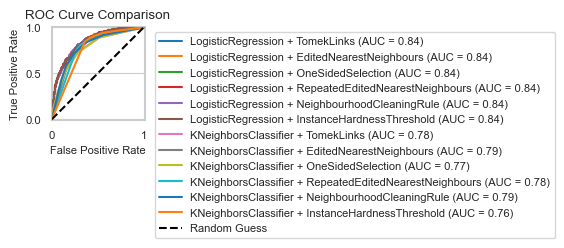

In [78]:
UnderSamplingResults = roc_auc_estimator(X_train, y_train, X_valid, y_valid, preprocessor, undersamplers, models)

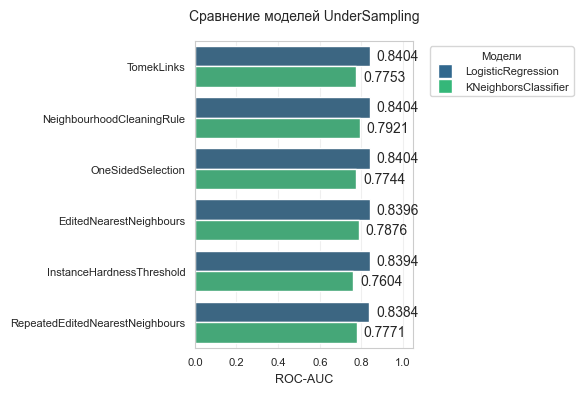

In [79]:
plot_roc_auc(UnderSamplingResults, 'Сравнение моделей UnderSampling')

#### 9.3 OverSampling

In [80]:
# Методы оверсэмплинга
oversamplers = {
    'SMOTE': SMOTE(random_state=42),
    'BorderlineSMOTE': BorderlineSMOTE(random_state=42, kind='borderline-1'),
    'SVM-SMOTE': SVMSMOTE(random_state=42),
    'KMeansSMOTE': KMeansSMOTE(cluster_balance_threshold=0.05, k_neighbors=3, random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'SMOTE+ENN': SMOTEENN(random_state=42)
}

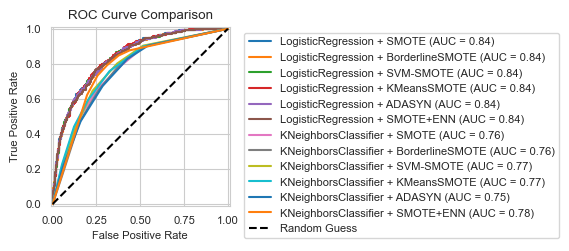

In [81]:
OverSamplingResults = roc_auc_estimator(X_train, y_train, X_valid, y_valid, preprocessor, oversamplers, models)

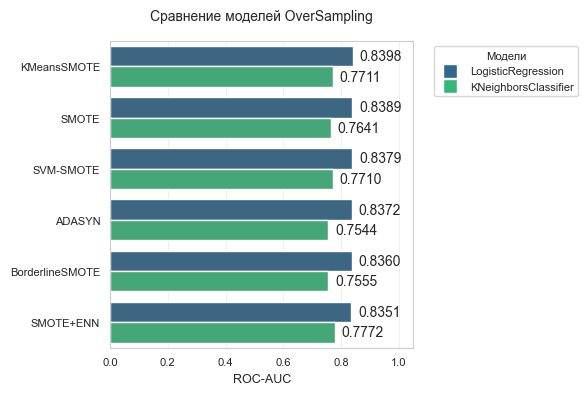

In [82]:
plot_roc_auc(OverSamplingResults, 'Сравнение моделей OverSampling')

#### 9.4 UnderSampling + OverSampling

In [83]:
# Варианты ресэмплинга
sampling_strategies = {
    'SMOTE+Tomek': (SMOTE(random_state=42), TomekLinks()),
    'ADASYN+ENN': (ADASYN(random_state=42), EditedNearestNeighbours()),
    'ADASYN+Tomek': (ADASYN(random_state=42), TomekLinks()),
    'SVMSMOTE+Tomek': (SVMSMOTE(random_state=42), TomekLinks()),
    'SMOTE+InstanceHardnessThreshold': (SMOTE(random_state=42), InstanceHardnessThreshold(estimator=LogisticRegression(C=10.0, max_iter=1000, random_state=42, solver='saga',
                   tol=0.001), random_state=42))
}

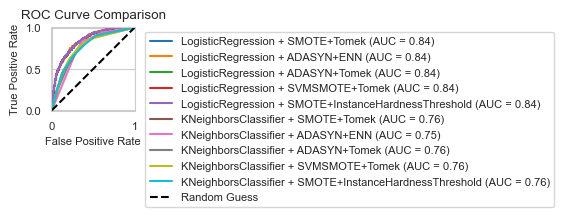

In [84]:
OverAndUnderSamplingResults = roc_auc_estimator(X_train, y_train, X_valid, y_valid, preprocessor, sampling_strategies, models)

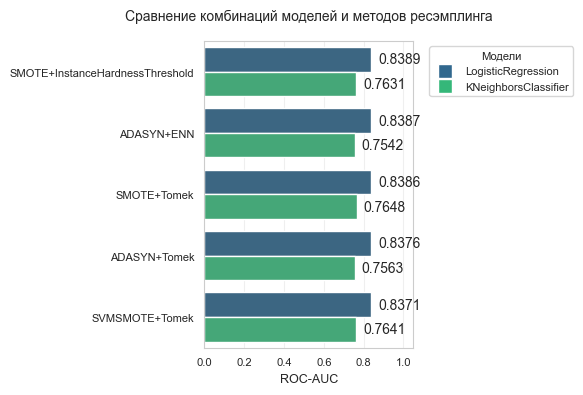

In [85]:
plot_roc_auc(OverAndUnderSamplingResults, 'Сравнение комбинаций моделей и методов ресэмплинга')

#### 9.5 Linear models

In [86]:
# Модели
models = {
    'LogisticRegression': LogisticRegression(
        solver='saga', # Используем 'saga' для стохастического градиентного спуска
        max_iter=1000,  # Максимальное количество итераций
        C=10.0, 
        penalty='l1',
        random_state=42,
        tol=0.001
    ),
    'SGDClassifier':  SGDClassifier(
        loss='log_loss',  # Используем логистическую регрессию через стохастический градиентный спуск
        max_iter=1000,  # Максимальное количество итераций
        tol=1e-4,  # Порог сходимости
        random_state=42)  # Для воспроизводимости
}

parameters_grid = {
    "LogisticRegression" : {
        'classifier__C': [100, 10, 1],  # Регуляризация
        'classifier__max_iter': [1000, 1600, 2000],  # Максимальное количество итераций
        'classifier__penalty': ['l2', 'l1'],  # Тип регуляризации
    },
    
    "SGDClassifier" : {
        'classifier__alpha': [0.0001, 0.001, 0.01],  # Регуляризация L2 (параметр alpha)
        'classifier__learning_rate': [
            'constant',
            'optimal',
            'adaptive'
        ],  # Стратегии шага градиентного спуска
        'classifier__eta0': [0.01, 0.1, 0.5],  # Начальный шаг градиентного спуска
        'classifier__max_iter': [1000, 2000],  # Максимальное количество итераций
        'classifier__tol': [1e-4, 1e-5],  # Порог сходимости
    }
}

# Вариант ресэмплинга
resampling = {
    'SMOTE_Tomek': (
        SMOTE( 
            random_state=42, # для воспроизводимости
            k_neighbors=5, # количество соседей для генерации синтетических примеров (по умолчанию 5)
            sampling_strategy='minority'
        ), 
        TomekLinks(
            sampling_strategy='auto',  # 'auto' удаляет только из большинственного класса
            n_jobs=-1 # использовать все ядра CPU
        )
    )
}


In [87]:
def GridSearch(X, y, pipeline, parameters_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1):
    # Создаем GridSearchCV для подбора гиперпараметров
    
    grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters_grid,
    cv=cv_strategy,
    scoring=['roc_auc', 'f1', 'precision', 'recall'],
    refit= scoring,
    verbose=verbose,
    n_jobs=n_jobs
    )

    # Обучаем модель с GridSearchCV
    return grid_search.fit(X, y)

In [88]:
def GridSearchPipe(X, y, models, preprocessor, parameters_grid, samplers = None, scoring='roc_auc'):
    
    grid_search = {}
    for model_name, model in models.items():
        if samplers is not None:
            for sampler_name, sampler in samplers.items():
                if not isinstance(sampler, tuple): continue
                over, under = sampler
                # Создаем pipeline
                pipeline = ImbPipeline([
                    ('preprocessor', preprocessor),
                    ('oversampler', over),
                    ('undersampler', under),
                    ('classifier', model)
                ])

                grid_search[model_name] = GridSearch(
                    X, y,
                    pipeline,
                    parameters_grid[model_name]
                )
                
        else:   
            # Создаем pipeline
            pipeline = ImbPipeline([
                        ('preprocessor', preprocessor),
                        ('classifier', model)
                    ])
            
            grid_search[model_name] = GridSearch(
                    X, y,
                    pipeline,
                    parameters_grid[model_name]
                )
        
    return grid_search

In [89]:
grid_search  = GridSearchPipe(
    X_train,
    y_train,
    models,
    preprocessor,
    parameters_grid,
    resampling,
    'recall'
)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [90]:
results = grid_search["LogisticRegression"].cv_results_

print(f"F1: {results['mean_test_f1'][grid_search["LogisticRegression"].best_index_]}")
print(f"Precision: {results['mean_test_precision'][grid_search["LogisticRegression"].best_index_]}")
print(f"Recall: {results['mean_test_recall'][grid_search["LogisticRegression"].best_index_]}")
print(f"AUC-ROC: {results['mean_test_roc_auc'][grid_search["LogisticRegression"].best_index_]}")

F1: 0.6021991968053022
Precision: 0.518429685891017
Recall: 0.719003670120898
AUC-ROC: 0.8254099221051762


In [91]:
# Выводим лучшие параметры
print(f"Best parameters: {grid_search["LogisticRegression"].best_params_}")

# Оцениваем на тестовой выборке
test_score = grid_search["LogisticRegression"].score(X_valid, y_valid)
print(f"Test set accuracy: {test_score:.4f}")

Best parameters: {'classifier__C': 1, 'classifier__max_iter': 1000, 'classifier__penalty': 'l1'}
Test set accuracy: 0.8383


In [92]:
# Выводим лучшие параметры
print(f"Best parameters: {grid_search["SGDClassifier"].best_params_}")

# Оцениваем на тестовой выборке
test_score = grid_search["SGDClassifier"].score(X_valid, y_valid)
print(f"Test set accuracy: {test_score:.4f}")

Best parameters: {'classifier__alpha': 0.0001, 'classifier__eta0': 0.1, 'classifier__learning_rate': 'adaptive', 'classifier__max_iter': 1000, 'classifier__tol': 0.0001}
Test set accuracy: 0.8388


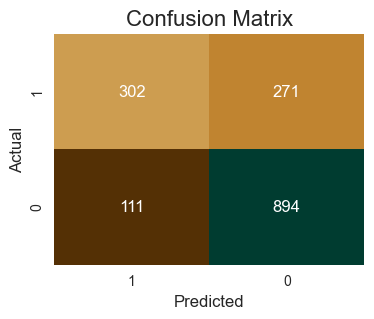

In [93]:
best_model = grid_search["LogisticRegression"].best_estimator_
y_pred_prob_logistic = best_model.predict_proba(X_valid)[:, 1]  # P(класс 1)
y_pred = (y_pred_prob_logistic >= 0.5).astype(int)

cm = confusion_matrix(y_valid, y_pred, labels=[0, 1])

TN, FP, FN, TP = cm.ravel()

fp_fn_data = pd.DataFrame({
    '1': [TP, FN],
    '0': [FP, TN]
}, index=['1', '0'])

# Построение хитмапы
plt.figure(figsize=(4, 3))
sns.heatmap(fp_fn_data, annot=True, cmap="BrBG", fmt='d', cbar=False,
            annot_kws={"size": 12})

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

**Precision (Точность) упал:** Это означает, что среди всех объектов, которые модель считает положительными, **увеличилась доля ложных срабатываний (False Positive, FP)**. Проще говоря, модель стала чаще кричать "Волк!" там, где его нет.

**Recall (Полнота) вырос:** Это означает, что модель теперь **находит большую долю реальных положительных объектов из всех существующих**. Она пропускает меньше целей (меньше False Negative, FN).

### 10.KNN

In [29]:
# Создаем трансформер для обработки данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature.numerical_idx(X_train)),  # Нормализация числовых признаков
        ('cat', OneHotEncoder(), feature.categorical_idx(X_train))  # Кодирование категориальных признаков
    ]
)

# Создаем полный пайплайн
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

PARAMS = {
    'classifier__n_neighbors': [3, 5, 7, 10, 20, 40, 45],
    'classifier__weights': ['uniform', 'distance'],  # Взвешенные соседи или нет
    'classifier__metric': ['manhattan', 'euclidean'],
}

# Стратегия кросс-валидации (стратифицируем по y, так как основную стратификацию уже сделали при создании выборки)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=PARAMS,
    cv=cv_strategy,
    scoring=['roc_auc', 'f1', 'precision', 'recall'],
    refit='roc_auc',
    n_jobs=-1
)

knn =  grid_search.fit(X_train.to_numpy(), y_train.to_numpy());

In [30]:
# Выводим лучшие параметры
print(f"Best parameters: {knn.best_params_}")

Best parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 40, 'classifier__weights': 'uniform'}


In [31]:
print(f"best score: {knn.best_score_}")

best score: 0.8261170841191076


### 11. CatBoost

In [43]:
catboost = CatBoostClassifier(
    cat_features=feature.categorical_idx(X_train),
    iterations=500,
    learning_rate=0.05,
    depth=4,
    early_stopping_rounds=20,
    eval_metric='AUC',
    random_seed=42,
    verbose=100
)

catboost.fit(
    X_train.to_numpy(),
    y_train.to_numpy(),
    eval_set = (X_valid.to_numpy(), y_valid.to_numpy()),
    use_best_model = True
)

y_pred = catboost.predict_proba(X_valid.to_numpy())[:,1]
print("ROC-AUC:", roc_auc_score(y_valid, y_pred))

Object info sizes: 3681 18
Object info sizes: 1578 18
0:	test: 0.7870735	best: 0.7870735 (0)	total: 33.6ms	remaining: 16.8s
100:	test: 0.8537707	best: 0.8537707 (100)	total: 4.39s	remaining: 17.3s
200:	test: 0.8553731	best: 0.8553731 (200)	total: 8.69s	remaining: 12.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8555082148
bestIteration = 228

Shrink model to first 229 iterations.
Object info sizes: 1578 18
ROC-AUC: 0.8555082147793285


In [45]:
# Подбор гиперпараметров для модели CatBoostClassifier
def objective(trial):

    params = {
        "iterations": trial.suggest_int("iterations", 300, 800),  # Количество итераций (деревьев)
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),  # Скорость обучения
        "depth": trial.suggest_int("depth", 3, 6),  # Глубина деревьев
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 10),  # L2-регуляризация
        "border_count": trial.suggest_categorical("border_count", [32, 64, 128, 254]),  # Количество границ для числовых признаков
        "random_strength": trial.suggest_int("random_strength", 1, 20),  # Сила случайности при выборе разделений
        "rsm": trial.suggest_float("rsm", 0.5, 1.0),  # Доля признаков для рассмотрения в каждом разделении
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),  # Стратегия роста деревьев
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian"]),  # Метод бустраппинга
        "loss_function": trial.suggest_categorical("loss_function", ["Logloss"]),  # Функция потерь
        "eval_metric": "Recall",  # Метрика оценки
        "verbose": False,  # Вывод информации о обучении
        "random_seed": 42,  # Случайное зерно для воспроизводимости
        "thread_count": 2,  # Количество ядер для CatBoost
        "early_stopping_rounds": 20,  # Количество раундов для ранней остановки
        "auto_class_weights": "Balanced"  # Автоматические веса классов для несбалансированных данных
    }
    
    # Указываем категориальные признаки
    params["cat_features"] = feature.categorical_idx(X_train)
    
    # --- пайплайн ---
    model = CatBoostClassifier(**params)

    # --- кросс-валидация ---
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    aucs, precisions, recalls = [], [], []
    for train_idx, valid_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.to_numpy()[train_idx], X_train.to_numpy()[valid_idx]
        y_tr, y_val = y_train.to_numpy()[train_idx], y_train.to_numpy()[valid_idx]

        # Обучение модели
        model.fit(X_tr, y_tr)

        # Предсказание модели
        y_pred = model.predict(X_val)
        # Предсказанные вероятности для первого класса
        y_proba = model.predict_proba(X_val)[:, 1]

        aucs.append(roc_auc_score(y_val, y_proba))
        precisions.append(precision_score(y_val, y_pred))
        recalls.append(recall_score(y_val, y_pred))

    metrics = {
        "roc_auc": np.mean(aucs),
        "precision": np.mean(precisions),
        "recall": np.mean(recalls)
    }

    # сохраняем гиперпараметры
    config_path = os.path.join(CONFIGS_DIR, f"params_and_metrics_{trial.number}.json")
    with open(config_path, "w") as f:
        json.dump({"params": params, "metrics": metrics}, f, indent=4)

    return metrics["recall"]

In [46]:
# --- запуск эксперимента ---
study = optuna.create_study(
    direction="maximize",
    study_name="my_study",
    storage="sqlite:///my_study.db",  # обязательно для параллелизма
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=42))

study.optimize(objective, n_trials=100, n_jobs=5);

[I 2025-11-28 14:19:54,064] Using an existing study with name 'my_study' instead of creating a new one.


Object info sizes: 2944 18
Object info sizes: 737 18
Object info sizes: 737 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Class weights type: Balanced
Weight of class 0: 1
Weight of class 1: 2.82965
Features checksum calculation time: 7.032163024e-05
Create new LearnProgress


[I 2025-11-28 14:21:31,890] Trial 102 finished with value: 0.8324913644214164 and parameters: {'iterations': 379, 'learning_rate': 0.023592001805173395, 'depth': 4, 'l2_leaf_reg': 10, 'border_count': 32, 'random_strength': 3, 'rsm': 0.8462427888646986, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 102 with value: 0.8324913644214164.
[I 2025-11-28 14:21:32,036] Trial 105 finished with value: 0.7794311312607944 and parameters: {'iterations': 380, 'learning_rate': 0.06615680076804623, 'depth': 4, 'l2_leaf_reg': 10, 'border_count': 32, 'random_strength': 3, 'rsm': 0.8075540355606049, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 102 with value: 0.8324913644214164.


Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2944 18


[I 2025-11-28 14:21:36,599] Trial 104 finished with value: 0.8231379533678757 and parameters: {'iterations': 398, 'learning_rate': 0.023474738090819385, 'depth': 4, 'l2_leaf_reg': 10, 'border_count': 32, 'random_strength': 3, 'rsm': 0.8496470102196212, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 102 with value: 0.8324913644214164.
[I 2025-11-28 14:21:36,771] Trial 103 finished with value: 0.8283246977547496 and parameters: {'iterations': 399, 'learning_rate': 0.02370756857272997, 'depth': 4, 'l2_leaf_reg': 10, 'border_count': 32, 'random_strength': 3, 'rsm': 0.902918383673505, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 102 with value: 0.8324913644214164.
[I 2025-11-28 14:21:37,531] Trial 101 finished with value: 0.8366634283246978 and parameters: {'iterations': 399, 'learning_rate': 0.023025758043688848, 'depth': 4, 'l2_leaf_reg': 10, 'border_count': 32, 'random_strength':

Object info sizes: 737 18
Object info sizes: 737 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18


[I 2025-11-28 14:23:08,460] Trial 107 finished with value: 0.7419958981001727 and parameters: {'iterations': 379, 'learning_rate': 0.12434669134649545, 'depth': 4, 'l2_leaf_reg': 10, 'border_count': 32, 'random_strength': 3, 'rsm': 0.8468863456938525, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 101 with value: 0.8366634283246978.
[I 2025-11-28 14:23:12,695] Trial 106 finished with value: 0.8304134283246978 and parameters: {'iterations': 398, 'learning_rate': 0.022511411702205487, 'depth': 4, 'l2_leaf_reg': 10, 'border_count': 32, 'random_strength': 3, 'rsm': 0.8470523873192329, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 101 with value: 0.8366634283246978.


Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2944 18


[I 2025-11-28 14:23:13,330] Trial 108 finished with value: 0.7461841537132988 and parameters: {'iterations': 379, 'learning_rate': 0.12850028639462416, 'depth': 4, 'l2_leaf_reg': 10, 'border_count': 32, 'random_strength': 3, 'rsm': 0.8479900587971959, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 101 with value: 0.8366634283246978.
[I 2025-11-28 14:23:17,001] Trial 109 finished with value: 0.8272884283246977 and parameters: {'iterations': 396, 'learning_rate': 0.024504818015530134, 'depth': 4, 'l2_leaf_reg': 10, 'border_count': 32, 'random_strength': 6, 'rsm': 0.8697695622103173, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 101 with value: 0.8366634283246978.
[I 2025-11-28 14:23:18,998] Trial 110 finished with value: 0.8366742227979275 and parameters: {'iterations': 398, 'learning_rate': 0.02374991141751953, 'depth': 4, 'l2_leaf_reg': 10, 'border_count': 32, 'random_strength':

Object info sizes: 737 18
Object info sizes: 737 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18


[I 2025-11-28 14:24:45,636] Trial 111 finished with value: 0.8283246977547496 and parameters: {'iterations': 394, 'learning_rate': 0.02492030828823983, 'depth': 4, 'l2_leaf_reg': 10, 'border_count': 32, 'random_strength': 4, 'rsm': 0.871567414114503, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:24:49,833] Trial 113 finished with value: 0.8314550949913644 and parameters: {'iterations': 393, 'learning_rate': 0.023868687409692176, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 6, 'rsm': 0.8585940189508752, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:24:49,973] Trial 112 finished with value: 0.8366634283246978 and parameters: {'iterations': 396, 'learning_rate': 0.02440867921219232, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 7,

Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2944 18


[I 2025-11-28 14:24:53,411] Trial 114 finished with value: 0.8345800949913643 and parameters: {'iterations': 394, 'learning_rate': 0.023074131443737187, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 6, 'rsm': 0.8748550904091866, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:24:55,698] Trial 115 finished with value: 0.8324967616580311 and parameters: {'iterations': 395, 'learning_rate': 0.0226807808853888, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 6, 'rsm': 0.8751026934728583, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.


Object info sizes: 737 18
Object info sizes: 737 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18


[I 2025-11-28 14:26:24,026] Trial 116 finished with value: 0.8127320811744386 and parameters: {'iterations': 399, 'learning_rate': 0.015449602006357902, 'depth': 4, 'l2_leaf_reg': 10, 'border_count': 32, 'random_strength': 6, 'rsm': 0.8630804368094559, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:26:26,805] Trial 117 finished with value: 0.8272938255613125 and parameters: {'iterations': 390, 'learning_rate': 0.023351590310501172, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 6, 'rsm': 0.875885942514678, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.


Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2944 18


[I 2025-11-28 14:26:27,331] Trial 118 finished with value: 0.8283300949913643 and parameters: {'iterations': 394, 'learning_rate': 0.023572835779062298, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 6, 'rsm': 0.8754437402294598, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:26:31,764] Trial 119 finished with value: 0.832496761658031 and parameters: {'iterations': 397, 'learning_rate': 0.024040579317017002, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 6, 'rsm': 0.8741266544259613, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:26:34,114] Trial 120 finished with value: 0.8283300949913646 and parameters: {'iterations': 396, 'learning_rate': 0.023700636647633434, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 6

Object info sizes: 737 18
Object info sizes: 737 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18


[I 2025-11-28 14:27:59,978] Trial 121 finished with value: 0.8293663644214163 and parameters: {'iterations': 392, 'learning_rate': 0.023302698599547395, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 7, 'rsm': 0.8780220174671224, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:28:02,391] Trial 123 finished with value: 0.8127266839378239 and parameters: {'iterations': 388, 'learning_rate': 0.01730319008682886, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 7, 'rsm': 0.8766001592647189, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:28:03,179] Trial 122 finished with value: 0.8220800949913645 and parameters: {'iterations': 393, 'learning_rate': 0.017307392549951676, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 7

Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2944 18


[I 2025-11-28 14:28:12,996] Trial 124 finished with value: 0.8168933506044904 and parameters: {'iterations': 414, 'learning_rate': 0.017409850116104714, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 7, 'rsm': 0.9078500886374414, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:28:15,807] Trial 125 finished with value: 0.8179134283246977 and parameters: {'iterations': 414, 'learning_rate': 0.016647979751076205, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 7, 'rsm': 0.9085507510823306, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.


Object info sizes: 737 18
Object info sizes: 737 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18


[I 2025-11-28 14:29:33,476] Trial 127 finished with value: 0.8148154145077721 and parameters: {'iterations': 374, 'learning_rate': 0.017314642703826173, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 7, 'rsm': 0.9000403386648989, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:29:41,598] Trial 126 finished with value: 0.8273046200345423 and parameters: {'iterations': 416, 'learning_rate': 0.01883665104616947, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 7, 'rsm': 0.9084313089298333, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:29:43,362] Trial 129 finished with value: 0.8335384283246977 and parameters: {'iterations': 371, 'learning_rate': 0.027591140503855024, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 6

Object info sizes: 736 18
Object info sizes: 2944 18


[I 2025-11-28 14:29:47,222] Trial 130 finished with value: 0.8231379533678757 and parameters: {'iterations': 375, 'learning_rate': 0.022522690279367822, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 8, 'rsm': 0.897056411256172, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.


Object info sizes: 737 18
Object info sizes: 737 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Class weights type: Balanced
Object info sizes: 2945 18
Weight of class 0: 1
Weight of class 1: 2.82965
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18


[I 2025-11-28 14:31:12,999] Trial 131 finished with value: 0.8293771588946459 and parameters: {'iterations': 409, 'learning_rate': 0.02658948455392486, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 6, 'rsm': 0.8360275934789153, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:31:13,144] Trial 133 finished with value: 0.8335438255613127 and parameters: {'iterations': 372, 'learning_rate': 0.027607964680465454, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 8, 'rsm': 0.8365677227676277, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:31:13,203] Trial 134 finished with value: 0.8283354922279793 and parameters: {'iterations': 369, 'learning_rate': 0.027913839253091065, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 6

Class weights type: Balanced
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2944 18


[I 2025-11-28 14:31:19,513] Trial 132 finished with value: 0.8293717616580312 and parameters: {'iterations': 404, 'learning_rate': 0.02730601382316197, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 8, 'rsm': 0.8331139694358248, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:31:20,309] Trial 135 finished with value: 0.8293717616580312 and parameters: {'iterations': 385, 'learning_rate': 0.027039490640118468, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 6, 'rsm': 0.8315716725818482, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.


Object info sizes: 737 18
Object info sizes: 737 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18


[I 2025-11-28 14:32:36,975] Trial 138 finished with value: 0.8304134283246978 and parameters: {'iterations': 348, 'learning_rate': 0.028233473881175673, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 5, 'rsm': 0.833580980785407, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:32:43,856] Trial 140 finished with value: 0.8345800949913645 and parameters: {'iterations': 346, 'learning_rate': 0.028327514622934157, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 5, 'rsm': 0.8360737834828778, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:32:44,070] Trial 139 finished with value: 0.8189766839378239 and parameters: {'iterations': 349, 'learning_rate': 0.020291691281013734, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 5

Object info sizes: 2944 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2944 18
Object info sizes: 737 18
Object info sizes: 737 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18


[I 2025-11-28 14:34:02,193] Trial 141 finished with value: 0.8200075561312608 and parameters: {'iterations': 351, 'learning_rate': 0.03553471254929651, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 5, 'rsm': 0.8575774266588206, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:34:07,321] Trial 143 finished with value: 0.8200291450777202 and parameters: {'iterations': 343, 'learning_rate': 0.03342917002168552, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 5, 'rsm': 0.8569388012407844, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:34:08,587] Trial 144 finished with value: 0.8075291450777202 and parameters: {'iterations': 344, 'learning_rate': 0.04427570341279616, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 5, 

Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2944 18


[I 2025-11-28 14:34:10,081] Trial 142 finished with value: 0.8116850172711573 and parameters: {'iterations': 354, 'learning_rate': 0.03537415326740158, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 5, 'rsm': 0.8550448303328988, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.


Object info sizes: 737 18
Object info sizes: 737 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18


[I 2025-11-28 14:35:31,490] Trial 146 finished with value: 0.8200021588946459 and parameters: {'iterations': 365, 'learning_rate': 0.020144641777880157, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 5, 'rsm': 0.8421011881229051, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:35:36,718] Trial 147 finished with value: 0.8137575561312607 and parameters: {'iterations': 364, 'learning_rate': 0.041814001801292494, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 5, 'rsm': 0.8402494928524039, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:35:36,991] Trial 148 finished with value: 0.8272884283246977 and parameters: {'iterations': 361, 'learning_rate': 0.020529129409058103, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 

Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2944 18
Object info sizes: 737 18
Object info sizes: 737 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18


[I 2025-11-28 14:37:08,205] Trial 153 finished with value: 0.8252104922279793 and parameters: {'iterations': 377, 'learning_rate': 0.029631961541284137, 'depth': 4, 'l2_leaf_reg': 7, 'border_count': 32, 'random_strength': 6, 'rsm': 0.8199871508125399, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:37:15,188] Trial 151 finished with value: 0.8127266839378239 and parameters: {'iterations': 426, 'learning_rate': 0.0299568291872574, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 6, 'rsm': 0.819161935309107, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:37:19,333] Trial 152 finished with value: 0.812721286701209 and parameters: {'iterations': 424, 'learning_rate': 0.03048413956874223, 'depth': 4, 'l2_leaf_reg': 7, 'border_count': 32, 'random_strength': 6, 'r

Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2944 18
Object info sizes: 737 18
Object info sizes: 737 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18


[I 2025-11-28 14:38:20,011] Trial 155 finished with value: 0.7960870034542313 and parameters: {'iterations': 666, 'learning_rate': 0.028121625273830508, 'depth': 4, 'l2_leaf_reg': 7, 'border_count': 64, 'random_strength': 6, 'rsm': 0.8873261116793671, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.


Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18


[I 2025-11-28 14:38:45,976] Trial 156 finished with value: 0.8210546200345423 and parameters: {'iterations': 405, 'learning_rate': 0.02880515559459211, 'depth': 4, 'l2_leaf_reg': 7, 'border_count': 64, 'random_strength': 4, 'rsm': 0.8900742946619851, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:38:53,670] Trial 157 finished with value: 0.8262521588946459 and parameters: {'iterations': 407, 'learning_rate': 0.026519223799750066, 'depth': 4, 'l2_leaf_reg': 7, 'border_count': 64, 'random_strength': 8, 'rsm': 0.8864537216296706, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:38:57,046] Trial 158 finished with value: 0.8252158894645941 and parameters: {'iterations': 406, 'learning_rate': 0.026342336882108432, 'depth': 4, 'l2_leaf_reg': 7, 'border_count': 32, 'random_strength': 8

Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2944 18
Object info sizes: 737 18
Object info sizes: 737 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18


[I 2025-11-28 14:39:57,678] Trial 160 finished with value: 0.8335438255613126 and parameters: {'iterations': 406, 'learning_rate': 0.025716936083508075, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 8, 'rsm': 0.8336007031281994, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.


Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18


[I 2025-11-28 14:40:17,977] Trial 161 finished with value: 0.8252104922279793 and parameters: {'iterations': 382, 'learning_rate': 0.025718469856005913, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 8, 'rsm': 0.8357067188217306, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:40:26,028] Trial 162 finished with value: 0.8231271588946459 and parameters: {'iterations': 382, 'learning_rate': 0.022516687256142535, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 7, 'rsm': 0.8310154301025162, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:40:29,873] Trial 163 finished with value: 0.8189658894645941 and parameters: {'iterations': 384, 'learning_rate': 0.022150684665765703, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 

Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2944 18
Object info sizes: 737 18
Object info sizes: 737 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18


[I 2025-11-28 14:41:31,325] Trial 165 finished with value: 0.823121761658031 and parameters: {'iterations': 384, 'learning_rate': 0.022902648613916405, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 7, 'rsm': 0.8646930859784203, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.


Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18


[I 2025-11-28 14:41:36,371] Trial 166 finished with value: 0.8179350172711572 and parameters: {'iterations': 324, 'learning_rate': 0.021413694626820814, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 9, 'rsm': 0.8630388679030162, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:41:48,521] Trial 168 finished with value: 0.8304242227979275 and parameters: {'iterations': 327, 'learning_rate': 0.03194628229840103, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 4, 'rsm': 0.8499215584356216, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:41:50,841] Trial 169 finished with value: 0.817940414507772 and parameters: {'iterations': 325, 'learning_rate': 0.01834723249950175, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 9, 

Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2944 18


[I 2025-11-28 14:41:59,259] Trial 167 finished with value: 0.8252212867012089 and parameters: {'iterations': 387, 'learning_rate': 0.021985106269768507, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 7, 'rsm': 0.8618414377693171, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.


Object info sizes: 737 18
Object info sizes: 737 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18


[I 2025-11-28 14:43:09,869] Trial 172 finished with value: 0.8293825561312609 and parameters: {'iterations': 336, 'learning_rate': 0.03266856412764367, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 9, 'rsm': 0.8066666582691828, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:43:13,523] Trial 171 finished with value: 0.8137683506044905 and parameters: {'iterations': 402, 'learning_rate': 0.03272541090639338, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 4, 'rsm': 0.8471448225916219, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:43:21,073] Trial 174 finished with value: 0.8158570811744387 and parameters: {'iterations': 337, 'learning_rate': 0.036730834626015785, 'depth': 4, 'l2_leaf_reg': 10, 'border_count': 32, 'random_strength': 4

Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2944 18
Object info sizes: 737 18
Object info sizes: 737 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18


[I 2025-11-28 14:44:35,874] Trial 176 finished with value: 0.8127374784110536 and parameters: {'iterations': 341, 'learning_rate': 0.03859718569415974, 'depth': 4, 'l2_leaf_reg': 10, 'border_count': 32, 'random_strength': 9, 'rsm': 0.8533115371416499, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:44:40,374] Trial 175 finished with value: 0.8179296200345423 and parameters: {'iterations': 373, 'learning_rate': 0.015262956087046333, 'depth': 4, 'l2_leaf_reg': 10, 'border_count': 32, 'random_strength': 5, 'rsm': 0.8490834188487337, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:44:41,655] Trial 178 finished with value: 0.8179296200345423 and parameters: {'iterations': 333, 'learning_rate': 0.024887748807222856, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength':

Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2944 18
Object info sizes: 737 18
Object info sizes: 737 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18


[I 2025-11-28 14:45:50,654] Trial 179 finished with value: 0.8283300949913646 and parameters: {'iterations': 308, 'learning_rate': 0.029829739353845714, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 5, 'rsm': 0.8777957147349036, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.


Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18


[I 2025-11-28 14:45:58,562] Trial 180 finished with value: 0.8262467616580311 and parameters: {'iterations': 324, 'learning_rate': 0.029792332712016176, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 8, 'rsm': 0.7994871578480536, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:46:02,789] Trial 182 finished with value: 0.8262521588946459 and parameters: {'iterations': 321, 'learning_rate': 0.030947385970345773, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 4, 'rsm': 0.8982007709558308, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:46:07,903] Trial 183 finished with value: 0.8304134283246978 and parameters: {'iterations': 314, 'learning_rate': 0.030099377561453616, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 

Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2944 18
Object info sizes: 736 18
Object info sizes: 736 18
Class weights type: Balanced
Weight of class 0: 1
Weight of class 1: 2.83333
Features checksum calculation time: 7.529021732e-05
Create new LearnProgress
Fold: Use owned online single ctrs
Fold: Use owned online single ctrs
Fold: Use owned online single ctrs
Fold: Use owned online single ctrs


[I 2025-11-28 14:46:08,069] Trial 181 finished with value: 0.8252158894645941 and parameters: {'iterations': 358, 'learning_rate': 0.029907883613005424, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 8, 'rsm': 0.8774247752111406, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.


Mem usage: Before start train: 262377472
Object info sizes: 2944 18
Started parallel calculation of 14 unique ctrs
Object info sizes: 737 18
Object info sizes: 737 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Class weights type: Balanced
Weight of class 0: 1
Weight of class 1: 2.82965
Features checksum calculation time: 7.616621904e-05


[I 2025-11-28 14:47:17,332] Trial 184 finished with value: 0.833533031088083 and parameters: {'iterations': 356, 'learning_rate': 0.026041679567238525, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 4, 'rsm': 0.7851514225815778, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:47:22,314] Trial 188 finished with value: 0.8262521588946459 and parameters: {'iterations': 307, 'learning_rate': 0.024874717513010233, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 4, 'rsm': 0.8277199723107612, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.


Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2944 18


[I 2025-11-28 14:47:22,513] Trial 187 finished with value: 0.7201478842832469 and parameters: {'iterations': 307, 'learning_rate': 0.2525054261198829, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 4, 'rsm': 0.8238513148461121, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:47:24,283] Trial 185 finished with value: 0.8106379533678757 and parameters: {'iterations': 352, 'learning_rate': 0.04855927966417396, 'depth': 4, 'l2_leaf_reg': 9, 'border_count': 32, 'random_strength': 4, 'rsm': 0.8271131860270301, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.


Object info sizes: 737 18
Object info sizes: 737 18
Object info sizes: 2945 18


[I 2025-11-28 14:47:42,434] Trial 186 finished with value: 0.8314550949913644 and parameters: {'iterations': 414, 'learning_rate': 0.0252259599715214, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 6, 'rsm': 0.8372697026952314, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.


Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18


[I 2025-11-28 14:48:53,061] Trial 189 finished with value: 0.8272938255613125 and parameters: {'iterations': 398, 'learning_rate': 0.025338105490355346, 'depth': 4, 'l2_leaf_reg': 10, 'border_count': 32, 'random_strength': 4, 'rsm': 0.8375486001825225, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:48:57,293] Trial 190 finished with value: 0.8272884283246977 and parameters: {'iterations': 395, 'learning_rate': 0.025260939291494366, 'depth': 4, 'l2_leaf_reg': 10, 'border_count': 32, 'random_strength': 4, 'rsm': 0.7800229332672973, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.


Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2944 18


[I 2025-11-28 14:48:58,212] Trial 191 finished with value: 0.8272884283246977 and parameters: {'iterations': 396, 'learning_rate': 0.025287385069590135, 'depth': 4, 'l2_leaf_reg': 10, 'border_count': 32, 'random_strength': 5, 'rsm': 0.8376953616522987, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.
[I 2025-11-28 14:49:00,877] Trial 192 finished with value: 0.8272938255613125 and parameters: {'iterations': 401, 'learning_rate': 0.025174239438360373, 'depth': 4, 'l2_leaf_reg': 10, 'border_count': 32, 'random_strength': 5, 'rsm': 0.8395935818010024, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 110 with value: 0.8366742227979275.


Object info sizes: 737 18
Object info sizes: 737 18
Object info sizes: 2945 18


[I 2025-11-28 14:49:18,300] Trial 193 finished with value: 0.8376889032815198 and parameters: {'iterations': 397, 'learning_rate': 0.025206565268584377, 'depth': 4, 'l2_leaf_reg': 10, 'border_count': 32, 'random_strength': 6, 'rsm': 0.7901443864812653, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 193 with value: 0.8376889032815198.


Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18


[I 2025-11-28 14:50:27,644] Trial 197 finished with value: 0.8272938255613125 and parameters: {'iterations': 359, 'learning_rate': 0.0216025509542976, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 6, 'rsm': 0.8668860836402521, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 193 with value: 0.8376889032815198.
[I 2025-11-28 14:50:34,098] Trial 194 finished with value: 0.8314550949913644 and parameters: {'iterations': 417, 'learning_rate': 0.02417519127134396, 'depth': 4, 'l2_leaf_reg': 10, 'border_count': 32, 'random_strength': 6, 'rsm': 0.8663744730504315, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 193 with value: 0.8376889032815198.
[I 2025-11-28 14:50:39,050] Trial 196 finished with value: 0.8324859671848014 and parameters: {'iterations': 416, 'learning_rate': 0.022122423639375804, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 6,

Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18


[I 2025-11-28 14:50:58,177] Trial 198 finished with value: 0.8262521588946459 and parameters: {'iterations': 418, 'learning_rate': 0.021873790014333705, 'depth': 4, 'l2_leaf_reg': 10, 'border_count': 32, 'random_strength': 6, 'rsm': 0.7890390078433439, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 193 with value: 0.8376889032815198.


Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 2945 18


[I 2025-11-28 14:51:58,820] Trial 199 finished with value: 0.8210600172711573 and parameters: {'iterations': 419, 'learning_rate': 0.019344373918777236, 'depth': 4, 'l2_leaf_reg': 10, 'border_count': 32, 'random_strength': 6, 'rsm': 0.8667626361632818, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 193 with value: 0.8376889032815198.


Object info sizes: 736 18
Object info sizes: 736 18


[I 2025-11-28 14:52:02,750] Trial 200 finished with value: 0.8241742227979275 and parameters: {'iterations': 413, 'learning_rate': 0.018703493982508798, 'depth': 4, 'l2_leaf_reg': 10, 'border_count': 32, 'random_strength': 6, 'rsm': 0.868111997718729, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 193 with value: 0.8376889032815198.


Object info sizes: 736 18
Object info sizes: 736 18


In [49]:
# --- обучение финальной модели ---
best_params = study.best_params
best_params["cat_features"] = feature.categorical_idx(X_train)
best_model = CatBoostClassifier(**best_params)

best_model.fit(
    X_train.to_numpy(),
    y_train.to_numpy(),
    eval_set = (X_valid.to_numpy(), y_valid.to_numpy()),
    use_best_model = True
)

Object info sizes: 3681 18
Object info sizes: 1578 18
0:	learn: 0.6777275	test: 0.6773919	best: 0.6773919 (0)	total: 36.1ms	remaining: 14.3s
1:	learn: 0.6634637	test: 0.6629307	best: 0.6629307 (1)	total: 77ms	remaining: 15.2s
2:	learn: 0.6510731	test: 0.6501632	best: 0.6501632 (2)	total: 119ms	remaining: 15.6s
3:	learn: 0.6407510	test: 0.6398753	best: 0.6398753 (3)	total: 158ms	remaining: 15.5s
4:	learn: 0.6318868	test: 0.6310135	best: 0.6310135 (4)	total: 199ms	remaining: 15.6s
5:	learn: 0.6225669	test: 0.6215871	best: 0.6215871 (5)	total: 237ms	remaining: 15.4s
6:	learn: 0.6145419	test: 0.6133599	best: 0.6133599 (6)	total: 277ms	remaining: 15.4s
7:	learn: 0.6067314	test: 0.6053381	best: 0.6053381 (7)	total: 324ms	remaining: 15.8s
8:	learn: 0.5984659	test: 0.5970410	best: 0.5970410 (8)	total: 363ms	remaining: 15.6s
9:	learn: 0.5905123	test: 0.5896521	best: 0.5896521 (9)	total: 403ms	remaining: 15.6s
10:	learn: 0.5826137	test: 0.5815512	best: 0.5815512 (10)	total: 441ms	remaining: 15.5

In [50]:
y_pred = best_model.predict_proba(X_valid.to_numpy())[:,1]
print("ROC-AUC:", roc_auc_score(y_valid, y_pred))

Object info sizes: 1578 18
ROC-AUC: 0.8552723191553482


In [51]:
# --- сохранение модели ---
model_path = os.path.join(MODELS_DIR, "catboost_best.pkl")
joblib.dump(best_model, model_path)

['models\\catboost_best.pkl']

In [48]:
model_path = os.path.join(MODELS_DIR, "catboost_best.pkl")
catboost = joblib.load(model_path)

### 12.Random Forest

In [33]:
# Создаем трансформер для обработки данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature.numerical_idx(X_train)),  # Нормализация числовых признаков
        ('cat', OneHotEncoder(), feature.categorical_idx(X_train))  # Кодирование категориальных признаков
    ]
)

# Создаем полный пайплайн
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

PARAMS = {
    "classifier__min_samples_split": [2, 5, 10, 20, 50, 100],  # range(2, 200),
    "classifier__min_samples_leaf": [1, 2, 5, 10, 20, 50]  # range(1, 200),
}

# Стратегия кросс-валидации (стратифицируем по y, так как основную стратификацию уже сделали при создании выборки)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=PARAMS,
    cv=cv_strategy,
    scoring=['roc_auc', 'f1', 'precision', 'recall'],
    refit='roc_auc',
    n_jobs=-1
)

rf =  grid_search.fit(X_train.to_numpy(), y_train.to_numpy());

In [34]:
print(f"Best score: {rf.best_score_}")
print(f"Best params: {rf.best_params_}")

Best score: 0.8388788997018821
Best params: {'classifier__min_samples_leaf': 20, 'classifier__min_samples_split': 50}


### 13. Stacking

In [35]:
class CustomStackingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_models, meta_model):
        self.base_models = base_models  # Уже обученные модели
        self.meta_model = meta_model
    
    def fit(self, X, y):
        # Используем предсказания уже обученных базовых моделей
        base_predictions = []
        for model in self.base_models:
            preds = model.predict_proba(X)  # Используем probability
            base_predictions.append(preds)
        
        # Объединяем предсказания
        X_meta = np.hstack(base_predictions)
        
        # Обучаем мета-модель на предсказаниях
        self.meta_model.fit(X_meta, y)
        return self
    
    def predict(self, X):
        base_predictions = []
        for model in self.base_models:
            preds = model.predict_proba(X)
            base_predictions.append(preds)
        
        X_meta = np.hstack(base_predictions)
        return self.meta_model.predict(X_meta)
    
    def predict_proba(self, X):
        base_predictions = []
        for model in self.base_models:
            preds = model.predict_proba(X)
            base_predictions.append(preds)
        
        X_meta = np.hstack(base_predictions)
        return self.meta_model.predict_proba(X_meta)


In [36]:
meta = CatBoostClassifier(
    iterations=25,
    grow_policy="Depthwise",
    learning_rate=0.02,
    border_count=128,
    l2_leaf_reg=8,
    depth=4,
    min_data_in_leaf=10,
    early_stopping_rounds=20,
    eval_metric='Recall',
    random_seed=42
)

custom_stacking = CustomStackingClassifier(
    base_models=[logreg, rf, knn, catboost],
    meta_model=meta
)

In [37]:
custom_stacking.fit(X_train.to_numpy(), y_train.to_numpy());

0:	learn: 0.6201873	total: 1.57ms	remaining: 37.6ms
1:	learn: 0.5286160	total: 2.91ms	remaining: 33.5ms
2:	learn: 0.6618106	total: 4.34ms	remaining: 31.8ms
3:	learn: 0.6482830	total: 5.8ms	remaining: 30.4ms
4:	learn: 0.6430801	total: 7.13ms	remaining: 28.5ms
5:	learn: 0.6430801	total: 8.36ms	remaining: 26.5ms
6:	learn: 0.6430801	total: 9.65ms	remaining: 24.8ms
7:	learn: 0.6201873	total: 10.6ms	remaining: 22.5ms
8:	learn: 0.6441207	total: 11.6ms	remaining: 20.7ms
9:	learn: 0.6441207	total: 12.6ms	remaining: 19ms
10:	learn: 0.6482830	total: 13.6ms	remaining: 17.4ms
11:	learn: 0.6472425	total: 14.7ms	remaining: 15.9ms
12:	learn: 0.6441207	total: 15.8ms	remaining: 14.6ms
13:	learn: 0.6285120	total: 17ms	remaining: 13.4ms
14:	learn: 0.6212279	total: 18.1ms	remaining: 12.1ms
15:	learn: 0.6243496	total: 19.3ms	remaining: 10.8ms
16:	learn: 0.6066597	total: 20.5ms	remaining: 9.65ms
17:	learn: 0.6149844	total: 21.6ms	remaining: 8.41ms
18:	learn: 0.6087409	total: 22.7ms	remaining: 7.15ms
19:	lear

In [41]:
y_pred = custom_stacking.predict_proba(X_valid.to_numpy())[:,1]
print("ROC-AUC:", roc_auc_score(y_valid, y_pred))

Object info sizes: 1578 18
Object info sizes: 1578 8
ROC-AUC: 0.8558376373026843


In [39]:
# Подбор гиперпараметров для модели CatBoostClassifier
def custom_stacking_gread(trial):

    params = {
        "iterations": trial.suggest_int("iterations", 300, 800),  # Количество итераций (деревьев)
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),  # Скорость обучения
        "depth": trial.suggest_int("depth", 3, 6),  # Глубина деревьев
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 10),  # L2-регуляризация
        "border_count": trial.suggest_categorical("border_count", [32, 64, 128, 254]),  # Количество границ для числовых признаков
        "random_strength": trial.suggest_int("random_strength", 1, 20),  # Сила случайности при выборе разделений
        "rsm": trial.suggest_float("rsm", 0.5, 1.0),  # Доля признаков для рассмотрения в каждом разделении
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),  # Стратегия роста деревьев
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian"]),  # Метод бустраппинга
        "loss_function": trial.suggest_categorical("loss_function", ["Logloss"]),  # Функция потерь
        "eval_metric": "Recall",  # Метрика оценки
        "verbose": False,  # Вывод информации о обучении
        "random_seed": 42,  # Случайное зерно для воспроизводимости
        "thread_count": 1,  # Количество ядер для CatBoost
        "early_stopping_rounds": 20,  # Количество раундов для ранней остановки
        "auto_class_weights": "Balanced"  # Автоматические веса классов для несбалансированных данных
    }

    # --- пайплайн ---
    model = CustomStackingClassifier(
        base_models=[logreg, rf, knn, catboost],
        meta_model= CatBoostClassifier(**params)
    )

    # --- кросс-валидация ---
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    aucs, precisions, recalls = [], [], []
    for train_idx, valid_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.to_numpy()[train_idx], X_train.to_numpy()[valid_idx]
        y_tr, y_val = y_train.to_numpy()[train_idx], y_train.to_numpy()[valid_idx]

        # Обучение модели
        model.fit(X_tr, y_tr)

        # Предсказание модели
        y_pred = model.predict(X_val)
        # Предсказанные вероятности для первого класса
        y_proba = model.predict_proba(X_val)[:, 1]

        aucs.append(roc_auc_score(y_val, y_proba))
        precisions.append(precision_score(y_val, y_pred))
        recalls.append(recall_score(y_val, y_pred))

    metrics = {
        "roc_auc": np.mean(aucs),
        "precision": np.mean(precisions),
        "recall": np.mean(recalls)
    }

    # # сохраняем гиперпараметры
    # config_path = os.path.join(CONFIGS_DIR, f"params_and_metrics_{trial.number}.json")
    # with open(config_path, "w") as f:
    #     json.dump({"params": params, "metrics": metrics}, f, indent=4)

    return metrics["recall"]

In [40]:
# --- запуск эксперимента ---
study = optuna.create_study(
    direction="maximize",
    study_name="custom_stacking_study",
    storage="sqlite:///my_study.db",  # обязательно для параллелизма
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=42))

study.optimize(custom_stacking_gread, n_trials=100, n_jobs=5);

[I 2025-11-28 12:40:19,273] Using an existing study with name 'custom_stacking_study' instead of creating a new one.


Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 8


[I 2025-11-28 12:40:28,063] Trial 112 finished with value: 0.8148154145077718 and parameters: {'iterations': 337, 'learning_rate': 0.0014779903240786515, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 2, 'rsm': 0.6184825064372639, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:40:28,420] Trial 113 finished with value: 0.817940414507772 and parameters: {'iterations': 336, 'learning_rate': 0.0010040229544996955, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 2, 'rsm': 0.6980443738422365, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.
[I 2025-11-28 12:40:28,585] Trial 111 finished with value: 0.8075291450777202 and parameters: {'iterations': 462, 'learning_rate': 0.00438991781304143, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 2, 'rsm': 0.6175417868046372, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.
[I 2025-11-28 12:40:29,774] Trial 114 finished with value: 0.8106541450777203 and parameters: {'iterations': 461, 'learning_rate': 0.004182819787913405, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 2,

Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8


[I 2025-11-28 12:40:30,005] Trial 115 finished with value: 0.8158624784110536 and parameters: {'iterations': 463, 'learning_rate': 0.001572772993815054, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 2, 'rsm': 0.6141249381976077, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 2944 18
Object info sizes: 2944 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 

[I 2025-11-28 12:40:36,992] Trial 117 finished with value: 0.8137737478411055 and parameters: {'iterations': 457, 'learning_rate': 0.0015664469218393806, 'depth': 5, 'l2_leaf_reg': 7, 'border_count': 64, 'random_strength': 3, 'rsm': 0.5892647257127331, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18


[I 2025-11-28 12:40:38,553] Trial 116 finished with value: 0.8127374784110536 and parameters: {'iterations': 460, 'learning_rate': 0.0023673877572927566, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 2, 'rsm': 0.5900114904961776, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:40:38,801] Trial 118 finished with value: 0.8137737478411055 and parameters: {'iterations': 752, 'learning_rate': 0.0011668960738336332, 'depth': 5, 'l2_leaf_reg': 7, 'border_count': 64, 'random_strength': 3, 'rsm': 0.567285488342134, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8


[I 2025-11-28 12:40:40,187] Trial 120 finished with value: 0.8106433506044904 and parameters: {'iterations': 425, 'learning_rate': 0.002263354624524711, 'depth': 5, 'l2_leaf_reg': 10, 'border_count': 254, 'random_strength': 1, 'rsm': 0.5912347433947448, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 737 18
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8


[I 2025-11-28 12:40:42,578] Trial 119 finished with value: 0.8106487478411054 and parameters: {'iterations': 746, 'learning_rate': 0.0015841401768777238, 'depth': 5, 'l2_leaf_reg': 7, 'border_count': 64, 'random_strength': 4, 'rsm': 0.5915741777291289, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 2945 8


[I 2025-11-28 12:40:46,864] Trial 123 finished with value: 0.8085654145077721 and parameters: {'iterations': 429, 'learning_rate': 0.0020563511046199977, 'depth': 5, 'l2_leaf_reg': 10, 'border_count': 128, 'random_strength': 1, 'rsm': 0.6324658377162378, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.
[I 2025-11-28 12:40:46,871] Trial 121 finished with value: 0.8116850172711573 and parameters: {'iterations': 424, 'learning_rate': 0.002301952639938761, 'depth': 5, 'l2_leaf_reg': 10, 'border_count': 254, 'random_strength': 1, 'rsm': 0.6376346918555192, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18


[I 2025-11-28 12:40:48,466] Trial 122 finished with value: 0.811690414507772 and parameters: {'iterations': 444, 'learning_rate': 0.0020441797246516175, 'depth': 5, 'l2_leaf_reg': 6, 'border_count': 128, 'random_strength': 1, 'rsm': 0.5646095840996085, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 8
Object info sizes: 2945 8


[I 2025-11-28 12:40:50,901] Trial 124 finished with value: 0.8085708117443868 and parameters: {'iterations': 444, 'learning_rate': 0.0020254119968354037, 'depth': 5, 'l2_leaf_reg': 10, 'border_count': 128, 'random_strength': 1, 'rsm': 0.6332281310292703, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:40:52,907] Trial 125 finished with value: 0.807534542314335 and parameters: {'iterations': 447, 'learning_rate': 0.0020480352801243258, 'depth': 5, 'l2_leaf_reg': 10, 'border_count': 128, 'random_strength': 1, 'rsm': 0.628512596722012, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:40:54,532] Trial 126 finished with value: 0.805440414507772 and parameters: {'iterations': 443, 'learning_rate': 0.0019655168784751182, 'depth': 5, 'l2_leaf_reg': 6, 'border_count': 32, 'random_strength': 1, 'rsm': 0.5776078029530435, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.
[I 2025-11-28 12:40:55,692] Trial 127 finished with value: 0.8043987478411054 and parameters: {'iterations': 441, 'learning_rate': 0.0019261517969294793, 'depth': 5, 'l2_leaf_reg': 6, 'border_count': 32, 'random_strength': 6, 'rsm': 0.6026127445931954, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2944 18
Object info sizes: 2944 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:40:58,415] Trial 128 finished with value: 0.8085654145077721 and parameters: {'iterations': 476, 'learning_rate': 0.0011987187935352734, 'depth': 5, 'l2_leaf_reg': 6, 'border_count': 32, 'random_strength': 3, 'rsm': 0.6010619204515276, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:41:00,198] Trial 129 finished with value: 0.8116850172711573 and parameters: {'iterations': 483, 'learning_rate': 0.0037102425655064384, 'depth': 5, 'l2_leaf_reg': 6, 'border_count': 32, 'random_strength': 3, 'rsm': 0.5778869142559887, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:41:02,169] Trial 130 finished with value: 0.8075237478411053 and parameters: {'iterations': 410, 'learning_rate': 0.003048937348043589, 'depth': 5, 'l2_leaf_reg': 9, 'border_count': 254, 'random_strength': 15, 'rsm': 0.6029814477144668, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.
[I 2025-11-28 12:41:02,994] Trial 131 finished with value: 0.805440414507772 and parameters: {'iterations': 408, 'learning_rate': 0.002952884425797344, 'depth': 5, 'l2_leaf_reg': 9, 'border_count': 254, 'random_strength': 15, 'rsm': 0.6032238648856277, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 2945 18
Object info sizes: 737 18
Object info sizes: 736 18
Object info sizes: 737 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:41:05,375] Trial 132 finished with value: 0.8096124784110537 and parameters: {'iterations': 412, 'learning_rate': 0.002992483620564906, 'depth': 5, 'l2_leaf_reg': 9, 'border_count': 254, 'random_strength': 2, 'rsm': 0.6067009454690311, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8


[I 2025-11-28 12:41:09,161] Trial 133 finished with value: 0.8158624784110536 and parameters: {'iterations': 409, 'learning_rate': 0.0017271224868793031, 'depth': 5, 'l2_leaf_reg': 9, 'border_count': 254, 'random_strength': 2, 'rsm': 0.6480776399351692, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:41:10,534] Trial 136 finished with value: 0.8168933506044904 and parameters: {'iterations': 317, 'learning_rate': 0.0017129590021426565, 'depth': 5, 'l2_leaf_reg': 7, 'border_count': 254, 'random_strength': 2, 'rsm': 0.6491397789605081, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8


[I 2025-11-28 12:41:11,143] Trial 134 finished with value: 0.8137791450777202 and parameters: {'iterations': 405, 'learning_rate': 0.003018886715766053, 'depth': 5, 'l2_leaf_reg': 9, 'border_count': 254, 'random_strength': 2, 'rsm': 0.6086716427030141, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 2944 18
Object info sizes: 2944 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:41:13,400] Trial 135 finished with value: 0.8168987478411054 and parameters: {'iterations': 433, 'learning_rate': 0.001750173033895548, 'depth': 5, 'l2_leaf_reg': 3, 'border_count': 254, 'random_strength': 2, 'rsm': 0.5817101283346301, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.
[I 2025-11-28 12:41:14,659] Trial 137 finished with value: 0.8158624784110536 and parameters: {'iterations': 309, 'learning_rate': 0.0017624953928437146, 'depth': 5, 'l2_leaf_reg': 7, 'border_count': 254, 'random_strength': 2, 'rsm': 0.6443299270051928, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Features checksum calculation time: 0.0002104104053
Create new LearnProgress
Fold: Use owned online single ctrs
Fold: Use owned online single ctrs
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18


[I 2025-11-28 12:41:19,830] Trial 138 finished with value: 0.8075237478411053 and parameters: {'iterations': 430, 'learning_rate': 0.002532565863299957, 'depth': 5, 'l2_leaf_reg': 3, 'border_count': 254, 'random_strength': 1, 'rsm': 0.5607528156720267, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 2944 8


[I 2025-11-28 12:41:20,674] Trial 140 finished with value: 0.8127320811744386 and parameters: {'iterations': 434, 'learning_rate': 0.0011616805159840211, 'depth': 4, 'l2_leaf_reg': 7, 'border_count': 254, 'random_strength': 1, 'rsm': 0.5580121437920332, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.
[I 2025-11-28 12:41:20,902] Trial 139 finished with value: 0.8075237478411055 and parameters: {'iterations': 428, 'learning_rate': 0.002581385823878214, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 1, 'rsm': 0.5806348681277768, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 2944 18


[I 2025-11-28 12:41:21,621] Trial 141 finished with value: 0.8127374784110536 and parameters: {'iterations': 311, 'learning_rate': 0.0014181013458531412, 'depth': 4, 'l2_leaf_reg': 7, 'border_count': 254, 'random_strength': 1, 'rsm': 0.5633273250912875, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Best gain for leaf #7 = 1.047302336
For node #7 built childs: 7 and 8with split: 2, bin=154 and score = 1.047302336
For node #2 built childs: 2 and 9with split: 1, bin=121 and score = 0.9585208419
For node #1 built childs: 1 and 10with split: 7, bin=224 and score = 0.8470873611
Best gain for leaf #1 = 1.239745067
For node #1 built childs: 1 and 2with split: 7, bin=114 and score = 2.393192798
Best gain for leaf #1 = 1.865402425
Best gain for leaf #2 = 1.227816341
Best gain for leaf #6 = 0.8756458168
For node #2 built childs: 2 and 7with split: 2, bin=154 and score = 1.227816341
For node #6 built childs: 6 and 8with split: 5, bin=25 and score = 0.8756458168
Best gain for leaf #0 = 15.92714885
For node #0 built childs: 0 and 1with split: 2, bin=127 and score = 15.92714885
Best gain for leaf #0 = 15.75991762
For node #0 built childs: 0 and 1with split: 2, bin=123 and score = 15.75991762
Best gain for leaf #0 = 2.870621604
For node #1 built childs: 1 and 6with split: 7, bin=143 and score = 

[I 2025-11-28 12:41:24,377] Trial 142 finished with value: 0.8085708117443868 and parameters: {'iterations': 430, 'learning_rate': 0.002551479656394393, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 1, 'rsm': 0.5715600420671328, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Best gain for leaf #1 = 0.9617314654
Best gain for leaf #4 = 1.725182625
For node #4 built childs: 4 and 5with split: 2, bin=124 and score = 1.725182625
For node #1 built childs: 1 and 6with split: 2, bin=245 and score = 0.9617314654
For node #3 built childs: 3 and 7with split: 2, bin=30 and score = 0.70835986
Best gain for leaf #7 = 0.8189707461
For node #7 built childs: 7 and 8with split: 1, bin=85 and score = 0.8189707461
For node #0 built childs: 0 and 9with split: 6, bin=43 and score = 0.358937537
Best gain for leaf #0 = 2.439089392
Best gain for leaf #9 = 2.061929949
For node #0 built childs: 0 and 10with split: 7, bin=227 and score = 2.439089392
For node #9 built childs: 9 and 11with split: 0, bin=43 and score = 2.061929949
For node #2 built childs: 2 and 12with split: 5, bin=16 and score = 0.09552163435
Best gain for leaf #0 = 1.596765066
Best gain for leaf #1 = 1.445692551
For node #0 built childs: 0 and 2with split: 7, bin=181 and score = 1.596765066
Best gain for leaf #0 = 3

[I 2025-11-28 12:41:27,279] Trial 143 finished with value: 0.8127266839378239 and parameters: {'iterations': 308, 'learning_rate': 0.0014138619711025068, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 1, 'rsm': 0.5316661948666138, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Best gain for leaf #0 = 16.3722037


[I 2025-11-28 12:41:27,659] Trial 145 finished with value: 0.8137791450777202 and parameters: {'iterations': 300, 'learning_rate': 0.0014780632398326415, 'depth': 4, 'l2_leaf_reg': 6, 'border_count': 254, 'random_strength': 1, 'rsm': 0.5710274096622546, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Best gain for leaf #8 = 2.331253876
Best gain for leaf #0 = 10.3485641
For node #8 built childs: 8 and 9with split: 3, bin=115 and score = 2.331253876
For node #5 built childs: 5 and 10with split: 0, bin=198 and score = 0.9651494744
For node #0 built childs: 0 and 1with split: 7, bin=166 and score = 10.3485641
Best gain for leaf #5 = 0.003880038567
Best gain for leaf #0 = 10.97568089
Best gain for leaf #10 = 1.941468821
Best gain for leaf #0 = 3.017094369
For node #0 built childs: 0 and 1with split: 3, bin=180 and score = 10.97568089
For node #10 built childs: 10 and 11with split: 6, bin=214 and score = 1.941468821
For node #4 built childs: 4 and 12with split: 7, bin=215 and score = 0.8561661567
Best gain for leaf #1 = 1.753761899
For node #0 built childs: 0 and 13with split: 2, bin=132 and score = 0.5936873996
Best gain for leaf #0 = 0.7731036624
For node #3 built childs: 3 and 14with split: 2, bin=143 and score = 0.5477907424
For node #5 built childs: 5 and 15with split: 7, bin=240 a

[I 2025-11-28 12:41:28,081] Trial 144 finished with value: 0.8189820811744386 and parameters: {'iterations': 305, 'learning_rate': 0.001404885209217012, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 1, 'rsm': 0.530110462933643, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Best gain for leaf #1 = 1.11121782
Best gain for leaf #1 = 1.122446488
Best gain for leaf #9 = 1.157294189
Best gain for leaf #0 = 19.63262471
For node #9 built childs: 9 and 10with split: 6, bin=67 and score = 1.157294189
For node #1 built childs: 1 and 11with split: 6, bin=8 and score = 0.5466038146
For node #0 built childs: 0 and 1with split: 1, bin=147 and score = 19.63262471
Best gain for leaf #0 = 13.43684943
Best gain for leaf #7 = 4.468776356
For node #7 built childs: 7 and 8with split: 4, bin=26 and score = 4.468776356
For node #0 built childs: 0 and 1with split: 0, bin=93 and score = 13.43684943
For node #0 built childs: 0 and 9with split: 1, bin=5 and score = 2.803610701
For node #5 built childs: 5 and 10with split: 2, bin=9 and score = 1.119085913
Best gain for leaf #0 = 1.220804116
Best gain for leaf #10 = 0.9336972438
For node #10 built childs: 10 and 11with split: 7, bin=173 and score = 0.9336972438
For node #1 built childs: 1 and 12with split: 1, bin=63 and score = 0.67

[I 2025-11-28 12:41:29,926] Trial 146 finished with value: 0.8158570811744387 and parameters: {'iterations': 327, 'learning_rate': 0.0012374522169149075, 'depth': 4, 'l2_leaf_reg': 6, 'border_count': 254, 'random_strength': 1, 'rsm': 0.5712770079894298, 'grow_policy': 'Lossguide', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Best gain for leaf #0 = 14.87646138
Best gain for leaf #5 = 2.770969087
For node #5 built childs: 5 and 6with split: 3, bin=182 and score = 2.770969087
For node #1 built childs: 1 and 7with split: 1, bin=196 and score = 2.026313587
For node #0 built childs: 0 and 8with split: 4, bin=35 and score = 1.766890034
For node #0 built childs: 0 and 1with split: 2, bin=81 and score = 14.87646138
Best gain for leaf #0 = 2.265170634
Best gain for leaf #0 = 0.7581307989
Best gain for leaf #8 = 2.020400423
Best gain for leaf #1 = 2.171555834
Best gain for leaf #1 = 0.2600189225
Best gain for leaf #0 = 18.61877945
Best gain for leaf #6 = 0.7627553544
For node #0 built childs: 0 and 1with split: 2, bin=139 and score = 18.61877945
For node #6 built childs: 6 and 7with split: 0, bin=125 and score = 0.7627553544
Best gain for leaf #0 = 4.671604651
Best gain for leaf #6 = 0.2065481656
Best gain for leaf #1 = 2.150104012
Best gain for leaf #7 = 1.110951448
For node #0 built childs: 0 and 2with split: 3, b

[I 2025-11-28 12:41:34,087] Trial 147 finished with value: 0.8148154145077721 and parameters: {'iterations': 351, 'learning_rate': 0.001278233480523912, 'depth': 4, 'l2_leaf_reg': 6, 'border_count': 254, 'random_strength': 1, 'rsm': 0.5926461903314927, 'grow_policy': 'Lossguide', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Best gain for leaf #0 = 20.07857663
Best gain for leaf #1 = 2.61180106
For node #0 built childs: 0 and 2with split: 3, bin=135 and score = 7.900342428
Best gain for leaf #0 = 2.641105086
Best gain for leaf #2 = 1.248875912
For node #0 built childs: 0 and 3with split: 6, bin=0 and score = 2.641105086
Best gain for leaf #3 = 1.962738606
For node #1 built childs: 1 and 4with split: 2, bin=35 and score = 2.61180106
For node #2 built childs: 2 and 3with split: 5, bin=27 and score = 2.902248997
Best gain for leaf #2 = 2.761222975
Class weights type: Balanced
Weight of class 0: 1
Weight of class 1: 2.82965
Features checksum calculation time: 3.468588013e-05
Create new LearnProgress
Fold: Use owned online single ctrs
Fold: Use owned online single ctrs
Best gain for leaf #3 = 3.30206422
For node #3 built childs: 3 and 4with split: 3, bin=114 and score = 3.30206422
For node #2 built childs: 2 and 5with split: 7, bin=192 and score = 2.761222975
For node #1 built childs: 1 and 6with split: 6, bin=

[I 2025-11-28 12:41:35,575] Trial 149 finished with value: 0.822096286701209 and parameters: {'iterations': 321, 'learning_rate': 0.001002497352595122, 'depth': 4, 'l2_leaf_reg': 6, 'border_count': 254, 'random_strength': 2, 'rsm': 0.9247556457586495, 'grow_policy': 'Lossguide', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


For node #6 built childs: 6 and 7with split: 2, bin=156 and score = 1.576304881
Best gain for leaf #6 = 1.384516095
Best gain for leaf #7 = 0.2551792691
For node #0 built childs: 0 and 8with split: 0, bin=145 and score = 1.384557293
Best gain for leaf #0 = 2.017699035
Best gain for leaf #8 = 2.046478091
For node #1 built childs: 1 and 2with split: 3, bin=73 and score = 1.618859126
Best gain for leaf #1 = 1.35259363
Best gain for leaf #2 = 0.0610261731
For node #1 built childs: 1 and 3with split: 1, bin=230 and score = 1.35259363
Best gain for leaf #1 = 1.024691578
For node #0 built childs: 0 and 4with split: 2, bin=25 and score = 1.237630855
Best gain for leaf #0 = 0.7167646446
Best gain for leaf #4 = 1.272788938
For node #4 built childs: 4 and 5with split: 3, bin=14 and score = 1.272788938
Best gain for leaf #5 = 0.6388629187
For node #1 built childs: 1 and 6with split: 4, bin=1 and score = 1.024691578
For node #0 built childs: 0 and 7with split: 3, bin=28 and score = 0.7167646446
Bes

[I 2025-11-28 12:41:35,900] Trial 148 finished with value: 0.817940414507772 and parameters: {'iterations': 325, 'learning_rate': 0.0012251979413232504, 'depth': 4, 'l2_leaf_reg': 6, 'border_count': 254, 'random_strength': 1, 'rsm': 0.596713798958151, 'grow_policy': 'Lossguide', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 2945 18
Object info sizes: 2945 8
Class weights type: Balanced
Weight of class 0: 1
Weight of class 1: 2.82965


[I 2025-11-28 12:41:36,748] Trial 150 finished with value: 0.8096124784110537 and parameters: {'iterations': 326, 'learning_rate': 0.0022550038566232955, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 1, 'rsm': 0.5941013627525353, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:41:40,161] Trial 151 finished with value: 0.8127374784110536 and parameters: {'iterations': 397, 'learning_rate': 0.002292474607525878, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 2, 'rsm': 0.5970521245944187, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:41:44,459] Trial 153 finished with value: 0.8127374784110536 and parameters: {'iterations': 391, 'learning_rate': 0.002190231752719368, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 2, 'rsm': 0.6161105669213066, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8


[I 2025-11-28 12:41:44,676] Trial 152 finished with value: 0.8117012089810016 and parameters: {'iterations': 397, 'learning_rate': 0.002184861878670655, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 2, 'rsm': 0.6160865922296376, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2944 18
Object info sizes: 2944 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 8


[I 2025-11-28 12:41:47,163] Trial 155 finished with value: 0.805440414507772 and parameters: {'iterations': 452, 'learning_rate': 0.0016322122387223746, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 12, 'rsm': 0.6233372177030064, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:41:47,603] Trial 154 finished with value: 0.8148208117443868 and parameters: {'iterations': 454, 'learning_rate': 0.0018699785795925285, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 2, 'rsm': 0.616336596068557, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:41:51,793] Trial 156 finished with value: 0.8137791450777202 and parameters: {'iterations': 452, 'learning_rate': 0.0015800189977887777, 'depth': 5, 'l2_leaf_reg': 7, 'border_count': 254, 'random_strength': 2, 'rsm': 0.6240516056284761, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 737 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8


[I 2025-11-28 12:41:54,646] Trial 157 finished with value: 0.8033678756476684 and parameters: {'iterations': 451, 'learning_rate': 0.012887443023491858, 'depth': 5, 'l2_leaf_reg': 7, 'border_count': 254, 'random_strength': 1, 'rsm': 0.6252701289186453, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:41:55,092] Trial 159 finished with value: 0.8064874784110536 and parameters: {'iterations': 364, 'learning_rate': 0.001834473103058851, 'depth': 5, 'l2_leaf_reg': 7, 'border_count': 64, 'random_strength': 1, 'rsm': 0.5818373203645947, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8


[I 2025-11-28 12:41:57,302] Trial 158 finished with value: 0.8116850172711573 and parameters: {'iterations': 453, 'learning_rate': 0.0017888810328049697, 'depth': 5, 'l2_leaf_reg': 7, 'border_count': 254, 'random_strength': 1, 'rsm': 0.6224541781525622, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8


[I 2025-11-28 12:41:59,441] Trial 160 finished with value: 0.8096016839378238 and parameters: {'iterations': 438, 'learning_rate': 0.0011319605864756055, 'depth': 5, 'l2_leaf_reg': 7, 'border_count': 254, 'random_strength': 1, 'rsm': 0.5831323773932883, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 737 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 8


[I 2025-11-28 12:42:03,592] Trial 161 finished with value: 0.8116850172711573 and parameters: {'iterations': 419, 'learning_rate': 0.001117146604607799, 'depth': 5, 'l2_leaf_reg': 7, 'border_count': 254, 'random_strength': 1, 'rsm': 0.5801893920706765, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:42:05,675] Trial 163 finished with value: 0.8096070811744387 and parameters: {'iterations': 418, 'learning_rate': 0.0010697276259674176, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 1, 'rsm': 0.5396997150436615, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:42:06,094] Trial 162 finished with value: 0.8106487478411054 and parameters: {'iterations': 420, 'learning_rate': 0.0011522412020187056, 'depth': 5, 'l2_leaf_reg': 7, 'border_count': 254, 'random_strength': 1, 'rsm': 0.9940657763169537, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:42:10,245] Trial 165 finished with value: 0.8002644645941277 and parameters: {'iterations': 416, 'learning_rate': 0.022621645823344617, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 1, 'rsm': 0.6090173680764936, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 8


[I 2025-11-28 12:42:10,811] Trial 164 finished with value: 0.7794473229706391 and parameters: {'iterations': 627, 'learning_rate': 0.02159612317887789, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 1, 'rsm': 0.5408667828936641, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2944 18
Object info sizes: 2944 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8


[I 2025-11-28 12:42:14,172] Trial 166 finished with value: 0.8127266839378239 and parameters: {'iterations': 423, 'learning_rate': 0.0012635033963949674, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 1, 'rsm': 0.598669843130106, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:42:17,187] Trial 168 finished with value: 0.8085762089810016 and parameters: {'iterations': 624, 'learning_rate': 0.001282457437493534, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 3, 'rsm': 0.6053041902599071, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Features checksum calculation time: 5.13010285e-05
Create new LearnProgress
Fold: Use owned online single ctrs


[I 2025-11-28 12:42:18,897] Trial 167 finished with value: 0.8096016839378238 and parameters: {'iterations': 639, 'learning_rate': 0.0013657953238522536, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 1, 'rsm': 0.6006448278092046, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8


[I 2025-11-28 12:42:19,144] Trial 169 finished with value: 0.8148208117443868 and parameters: {'iterations': 436, 'learning_rate': 0.0015316127621185305, 'depth': 5, 'l2_leaf_reg': 9, 'border_count': 64, 'random_strength': 2, 'rsm': 0.6602934978560278, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 2944 18
Object info sizes: 2944 8
Fold: Use owned online single ctrs
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:42:22,066] Trial 170 finished with value: 0.6712219343696028 and parameters: {'iterations': 437, 'learning_rate': 0.11265205760733445, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 2, 'rsm': 0.5997348280443553, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8


[I 2025-11-28 12:42:24,041] Trial 171 finished with value: 0.8158624784110536 and parameters: {'iterations': 438, 'learning_rate': 0.0015274575378179363, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 2, 'rsm': 0.6077614847596713, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Class weights type: Balanced
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8


[I 2025-11-28 12:42:28,034] Trial 172 finished with value: 0.8169041450777202 and parameters: {'iterations': 437, 'learning_rate': 0.0015213299057715468, 'depth': 5, 'l2_leaf_reg': 9, 'border_count': 254, 'random_strength': 2, 'rsm': 0.9576981331130737, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:42:29,956] Trial 173 finished with value: 0.8169041450777202 and parameters: {'iterations': 435, 'learning_rate': 0.0010466693438788803, 'depth': 5, 'l2_leaf_reg': 9, 'border_count': 254, 'random_strength': 2, 'rsm': 0.5889039100167369, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2944 18
Object info sizes: 2944 8


[I 2025-11-28 12:42:30,678] Trial 174 finished with value: 0.8127374784110536 and parameters: {'iterations': 493, 'learning_rate': 0.0010579878417541176, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 2, 'rsm': 0.5902330949305453, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


7, bin=230 score 21.40745046
6, bin=38 score 16.1181985
7, bin=214 score 17.2495091
3, bin=53 score 17.94421278
3, bin=196 score 17.40754847

6, bin=100 score 9.148115027
4, bin=32 score 7.981493959

3, bin=144 score 8.192816288
Object info sizes: 2945 18
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8


[I 2025-11-28 12:42:32,768] Trial 175 finished with value: 0.8096070811744387 and parameters: {'iterations': 475, 'learning_rate': 0.001980159732887637, 'depth': 5, 'l2_leaf_reg': 9, 'border_count': 254, 'random_strength': 1, 'rsm': 0.5573714015963871, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Class weights type: Balanced
Weight of class 0: 1
Weight of class 1: 2.82965
Features checksum calculation time: 6.862597502e-05
Create new LearnProgress
Fold: Use owned online single ctrs
Fold: Use owned online single ctrs
Mem usage: Before start train: 527351808

3, bin=133 score 20.79963583
1, bin=181 score 21.25725444
2, bin=140 score 19.64586322
0, bin=30 score 22.26943867
4, bin=23 score 20.81230767

7, bin=131 score 18.72615589
6, bin=70 score 20.46307614
2, bin=200 score 20.89262943
1, bin=183 score 20.47975182
2, bin=144 score 21.38363963

2, bin=138 score 18.50737256
6, bin=26 score 20.96666494
6, bin=75 score 21.18216195
0, bin=164 score 21.4160142
2, bin=81 score 21.41367474

7, bin=112 score 18.78782404
5, bin=17 score 20.92933233
7, bin=103 score 20.936114
3, bin=203 sc

[I 2025-11-28 12:42:35,539] Trial 176 finished with value: 0.8096070811744387 and parameters: {'iterations': 469, 'learning_rate': 0.002074842634967621, 'depth': 5, 'l2_leaf_reg': 9, 'border_count': 254, 'random_strength': 1, 'rsm': 0.8902701616202489, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


3, bin=145 score 14.8959329
2, bin=37 score 15.87403077
7, bin=68 score 17.04774848
2, bin=231 score 17.24860951

2, bin=101 score 14.85778634
3, bin=67 score 15.35953106
6, bin=48 score 17.43662207
0, bin=179 score 17.71655254
2, bin=77 score 12.02189646
6, bin=77 score 12.48627992

7, bin=129 score 11.87208619
3, bin=60 score 11.37995053
3, bin=160 score 11.35227454
7, bin=148 score 10.12266617
1, bin=109 score 11.7176517
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8

0, bin=92 score 18.46706579
5, bin=5 score 18.40996572
2, bin=83 score 19.87261679
0, bin=142 score 19.51065206
1, bin=229 score 16.09496923
1, bin=211 score 16.24034329
3, bin=166 score 16.20226072

2, bin=118 score 15.7162576
3, bin=185 score 15.69987407
3, bin=96 score 16.3773232
3, bin=249 score 16.44415526
6, bin=253 score 16.74538087

2, bin=114 score 14.63

[I 2025-11-28 12:42:37,859] Trial 177 finished with value: 0.8096070811744387 and parameters: {'iterations': 475, 'learning_rate': 0.0010222081824229718, 'depth': 5, 'l2_leaf_reg': 6, 'border_count': 254, 'random_strength': 1, 'rsm': 0.5568082183182711, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


7, bin=173 score 14.3928579
2, bin=71 score 15.12448098
1, bin=184 score 14.92251253

2, bin=102 score 13.03479224
6, bin=72 score 13.85216405
6, bin=33 score 13.69180581
3, bin=52 score 13.6214998
1, bin=203 score 14.45475798

3, bin=141 score 12.0885865
2, bin=51 score 12.16118309
6, bin=98 score 11.76482223
2, bin=171 score 14.18855728
2, bin=168 score 14.49663115

5, bin=10 score 12.47991524
6, bin=37 score 13.33377895
0, bin=144 score 13.58884229
0, bin=63 score 13.27059703
6, bin=131 score 14.52411321

3, bin=123 score 12.62762801
7, bin=194 score 14.26032593
4, bin=33 score 13.63588149
0, bin=177 score 14.82370032
6, bin=180 score 14.59432073
Object info sizes: 736 18

6, bin=110 score 13.84358379
3, bin=80 score 13.50929127
7, bin=204 score 15.19803005
3, bin=97 score 14.78019213
Object info sizes: 736 8
4, bin=9 score 14.25833877

2, bin=126 score 13.03535721
6, bin=49 score 13.58637131
1, bin=0 score 13.99336973
5, bin=2 score 14.9843159
4, bin=7 score 14.44127414

6, bin=86 

[I 2025-11-28 12:42:41,228] Trial 179 finished with value: 0.807534542314335 and parameters: {'iterations': 475, 'learning_rate': 0.001977173419097182, 'depth': 5, 'l2_leaf_reg': 6, 'border_count': 254, 'random_strength': 1, 'rsm': 0.56333996306958, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 2944 18
Object info sizes: 2944 8
Object info sizes: 2945 8


[I 2025-11-28 12:42:42,571] Trial 178 finished with value: 0.8096016839378238 and parameters: {'iterations': 494, 'learning_rate': 0.001996428989945512, 'depth': 5, 'l2_leaf_reg': 6, 'border_count': 254, 'random_strength': 1, 'rsm': 0.732187768257328, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.
[I 2025-11-28 12:42:43,175] Trial 180 finished with value: 0.8075291450777202 and parameters: {'iterations': 445, 'learning_rate': 0.002659969765348495, 'depth': 5, 'l2_leaf_reg': 1, 'border_count': 254, 'random_strength': 1, 'rsm': 0.610816635850126, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 2944 18
Object info sizes: 2944 8


[I 2025-11-28 12:42:45,795] Trial 181 finished with value: 0.8116850172711573 and parameters: {'iterations': 445, 'learning_rate': 0.0027368124494979757, 'depth': 5, 'l2_leaf_reg': 2, 'border_count': 254, 'random_strength': 1, 'rsm': 0.6364195169135227, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 2944 18
Object info sizes: 2944 8


[I 2025-11-28 12:42:47,259] Trial 182 finished with value: 0.8075237478411055 and parameters: {'iterations': 428, 'learning_rate': 0.0027754147430852473, 'depth': 5, 'l2_leaf_reg': 1, 'border_count': 254, 'random_strength': 1, 'rsm': 0.7288568885159026, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.
[I 2025-11-28 12:42:51,948] Trial 183 finished with value: 0.8096124784110537 and parameters: {'iterations': 446, 'learning_rate': 0.0026520886224772554, 'depth': 5, 'l2_leaf_reg': 7, 'border_count': 254, 'random_strength': 1, 'rsm': 0.6365756927731676, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.
[I 2025-11-28 12:42:52,658] Trial 184 finished with value: 0.8054512089810016 and parameters: {'iterations': 447, 'learning_rate': 0.002667518192865287, 'depth': 5, 'l2_leaf_reg': 2, 'border_count': 254, 'random_strength':

Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2944 18
Object info sizes: 2944 8
Class weights type: Balanced
Weight of class 0: 1
Weight of class 1: 2.83333
Features checksum calculation time: 3.769032929e-05
Create new LearnProgress
Fold: Use owned online single ctrs
Fold: Use owned online single ctrs
Object info sizes: 2945 8
Object info sizes: 737 18
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8


[I 2025-11-28 12:42:54,470] Trial 187 finished with value: 0.8075291450777202 and parameters: {'iterations': 461, 'learning_rate': 0.0017495303652630663, 'depth': 5, 'l2_leaf_reg': 7, 'border_count': 64, 'random_strength': 8, 'rsm': 0.5779919093682965, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:42:54,879] Trial 186 finished with value: 0.8044041450777202 and parameters: {'iterations': 460, 'learning_rate': 0.0017403389813284802, 'depth': 5, 'l2_leaf_reg': 1, 'border_count': 64, 'random_strength': 1, 'rsm': 0.5735047804699998, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:42:57,698] Trial 185 finished with value: 0.8085654145077721 and parameters: {'iterations': 674, 'learning_rate': 0.00168776658133497, 'depth': 5, 'l2_leaf_reg': 2, 'border_count': 254, 'random_strength': 1, 'rsm': 0.6358033764549836, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 2945 18
Object info sizes: 736 18
Object info sizes: 2945 8


[I 2025-11-28 12:43:00,618] Trial 189 finished with value: 0.8085654145077721 and parameters: {'iterations': 341, 'learning_rate': 0.0016967519169581928, 'depth': 5, 'l2_leaf_reg': 6, 'border_count': 64, 'random_strength': 8, 'rsm': 0.8388430852271278, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:43:02,582] Trial 188 finished with value: 0.8137737478411055 and parameters: {'iterations': 463, 'learning_rate': 0.0016897306696944958, 'depth': 5, 'l2_leaf_reg': 10, 'border_count': 254, 'random_strength': 2, 'rsm': 0.5733949214102786, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.
[I 2025-11-28 12:43:04,211] Trial 190 finished with value: 0.8148208117443868 and parameters: {'iterations': 406, 'learning_rate': 0.002335065248744914, 'depth': 5, 'l2_leaf_reg': 10, 'border_count': 254, 'random_strength': 2, 'rsm': 0.841875373516744, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Class weights type: Balanced
Weight of class 0: 1
Weight of class 1: 2.82965
Features checksum calculation time: 4.088607828e-05
Create new LearnProgress
Fold: Use owned online single ctrs
Fold: Use owned online single ctrs
Mem usage: Before start train: 513581056
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8


[I 2025-11-28 12:43:04,608] Trial 191 finished with value: 0.8168987478411054 and parameters: {'iterations': 410, 'learning_rate': 0.002453559034330852, 'depth': 5, 'l2_leaf_reg': 10, 'border_count': 254, 'random_strength': 2, 'rsm': 0.5894700778922894, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 2944 18
Object info sizes: 2944 8


[I 2025-11-28 12:43:06,318] Trial 192 finished with value: 0.7888007340241796 and parameters: {'iterations': 300, 'learning_rate': 0.04463218700367496, 'depth': 5, 'l2_leaf_reg': 10, 'border_count': 254, 'random_strength': 2, 'rsm': 0.5947797653896658, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 737 18
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 8
Object info sizes: 2945 8


[I 2025-11-28 12:43:08,748] Trial 193 finished with value: 0.8168987478411054 and parameters: {'iterations': 300, 'learning_rate': 0.002282996851392383, 'depth': 5, 'l2_leaf_reg': 10, 'border_count': 254, 'random_strength': 2, 'rsm': 0.5944532893381271, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Class weights type: Balanced
Weight of class 0: 1
Weight of class 1: 2.82965
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:43:12,848] Trial 194 finished with value: 0.8158678756476684 and parameters: {'iterations': 407, 'learning_rate': 0.002122912666628467, 'depth': 5, 'l2_leaf_reg': 10, 'border_count': 254, 'random_strength': 2, 'rsm': 0.592665115785606, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8


[I 2025-11-28 12:43:13,483] Trial 196 finished with value: 0.8085654145077721 and parameters: {'iterations': 302, 'learning_rate': 0.0013334859768542344, 'depth': 5, 'l2_leaf_reg': 10, 'border_count': 254, 'random_strength': 1, 'rsm': 0.6052338232275128, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 2944 18
Object info sizes: 2945 18
Object info sizes: 2944 8


[I 2025-11-28 12:43:13,899] Trial 195 finished with value: 0.8106433506044904 and parameters: {'iterations': 424, 'learning_rate': 0.002291181295937842, 'depth': 5, 'l2_leaf_reg': 10, 'border_count': 254, 'random_strength': 1, 'rsm': 0.5914459218481385, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8


[I 2025-11-28 12:43:17,978] Trial 197 finished with value: 0.8106487478411054 and parameters: {'iterations': 429, 'learning_rate': 0.0012841070584913119, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 1, 'rsm': 0.6124989019632735, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 2945 18
Object info sizes: 2945 8
Features checksum calculation time: 5.205438998e-05


[I 2025-11-28 12:43:19,793] Trial 198 finished with value: 0.8096070811744388 and parameters: {'iterations': 380, 'learning_rate': 0.0013656725934430593, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 1, 'rsm': 0.7793545583476501, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 737 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 2945 18
Object info sizes: 736 8
Object info sizes: 2945 8


[I 2025-11-28 12:43:24,321] Trial 199 finished with value: 0.8096070811744387 and parameters: {'iterations': 426, 'learning_rate': 0.0013391498012908546, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 1, 'rsm': 0.6062979386209603, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.
[I 2025-11-28 12:43:24,980] Trial 201 finished with value: 0.8075291450777202 and parameters: {'iterations': 586, 'learning_rate': 0.00192636192361533, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 1, 'rsm': 0.6131276744441491, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:43:25,695] Trial 200 finished with value: 0.8096070811744387 and parameters: {'iterations': 549, 'learning_rate': 0.0011945310369046605, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 1, 'rsm': 0.6163871342095765, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.
[I 2025-11-28 12:43:26,959] Trial 202 finished with value: 0.8085654145077721 and parameters: {'iterations': 315, 'learning_rate': 0.003389644201597496, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 1, 'rsm': 0.6255870228260265, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:43:29,006] Trial 203 finished with value: 0.8106487478411054 and parameters: {'iterations': 314, 'learning_rate': 0.0019471663317354405, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 1, 'rsm': 0.6226903829072233, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 737 18
Object info sizes: 737 8
Object info sizes: 2944 18
Object info sizes: 2944 8

6, bin=121 score 18.03860908
Features checksum calculation time: 4.416942744e-05
Create new LearnProgress
Fold: Use owned online single ctrs
Fold: Use owned online single ctrs

2, bin=126 score 16.87418936
2, bin=79 score 18.22854409
2, bin=191 score 18.94907308

2, bin=115 score 16.82765731
3, bin=96 score 16.58221436
4, bin=28 score 18.43345063
7, bin=241 score 17.10585327

1, bin=151 score 17.59384937
7, bin=144 score 16.37812593
5, bin=26 score 18.45012469

2, bin=101 score 18.4

[I 2025-11-28 12:43:33,178] Trial 204 finished with value: 0.8085708117443868 and parameters: {'iterations': 319, 'learning_rate': 0.002079345474531164, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 1, 'rsm': 0.6206907071959016, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 2945 18
Object info sizes: 2945 8
3, bin=11 score 19.54301052
3, bin=172 score 18.97177082

4, bin=9 score 14.98837538
0, bin=65 score 10.01349865

6, bin=83 score 9.03909442
1, bin=83 score 10.13221532

4, bin=21 score 9.669899373
6, bin=109 score 17.19713508
4, bin=14 score 20.05414916
4, bin=21 score 18.0330402

1, bin=71 score 19.58799469
6, bin=60 score 7.291472099
6, bin=74 score 20.09363616
2, bin=151 score 7.61605145
4, bin=7 score 7.986523441


6, bin=86 score 8.600443581
4, bin=26 score 19.23761792
2, bin=23 score 17.40394463
0, bin=238 score 8.967321846
6, bin=90 score 19.94542933
Object info sizes: 736 18

7, bin=165 score 15.31653399
Object info sizes: 736 8

Object info sizes: 736 18

Object info sizes: 736 8

7, bin=170 score 12.80722714
Object info sizes: 2945 18
5, bin=20 score 13.32919506
Object info sizes: 2945 8

6, bin=79 score 13.01129404
3, bin=99 score 11.47706085
3, bin=84 score 15.15022813
6, bin=190 score 13.44289901

2, bin=112 score 12.07

[I 2025-11-28 12:43:35,343] Trial 206 finished with value: 0.811690414507772 and parameters: {'iterations': 434, 'learning_rate': 0.002111166162601185, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 1, 'rsm': 0.6236790644931844, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.



5, bin=11 score 10.91374715
2, bin=127 score 12.29572774
4, bin=12 score 13.73517118
7, bin=144 score 12.31556429

7, bin=160 score 11.20784132
6, bin=164 score 12.15278448
0, bin=138 score 12.53712665
3, bin=217 score 12.87903524

7, bin=167 score 12.31465636
5, bin=0 score 12.5624973
7, bin=64 score 12.97628786
3, bin=219 score 12.11393384

3, bin=155 score 9.879906484
2, bin=42 score 11.53890772
7, bin=67 score 11.77849979
2, bin=13 score 12.226963

7, bin=127 score 10.14105432
5, bin=23 score 10.81700858
4, bin=24 score 11.52289956
2, bin=169 score 11.25420278

7, bin=120 score 11.54722921
4, bin=22 score 11.25881594
5, bin=0 score 11.93106057
7, bin=227 score 11.39835635

6, bin=63 score 11.681935
6, bin=131 score 12.28653035
1, bin=67 score 11.52257428
2, bin=125 score 12.26233845

4, bin=17 score 11.47462479
5, bin=4 score 11.69996103
6, bin=80 score 11.55213729
0, bin=117 score 12.3032729

7, bin=131 score 9.499135191
5, bin=2 score 11.34066156
0, bin=39 score 11.90363713
4, b

[I 2025-11-28 12:43:35,959] Trial 205 finished with value: 0.8106433506044904 and parameters: {'iterations': 533, 'learning_rate': 0.0034681350139621338, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 254, 'random_strength': 1, 'rsm': 0.5821475677622991, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.






Object info sizes: 2945 18
7, bin=134 score 14.26420227
Object info sizes: 2945 8
2, bin=130 score 14.34968635
7, bin=3 score 14.98786441
7, bin=104 score 13.72987165
0, bin=76 score 13.37987599
6, bin=87 score 12.16193786
1, bin=138 score 14.038858
3, bin=128 score 14.57925882

7, bin=130 score 11.06856753
3, bin=199 score 13.33421586
4, bin=22 score 12.8363029

2, bin=108 score 16.16595689
7, bin=185 score 17.45333099
5, bin=5 score 17.34451044
7, bin=223 score 17.76094069

7, bin=149 score 15.23646812
7, bin=204 score 16.87225286
7, bin=11 score 16.51375211
6, bin=87 score 15.74262479

2, bin=110 score 14.68344601
4, bin=20 score 16.27874912
3, bin=100 score 15.74164387
3, bin=123 score 16.00147233

2, bin=72 score 15.33090898
0, bin=181 score 17.03809266
3, bin=74 score 16.65939091
3, bin=179 score 17.16906006

7, bin=164 score 16.37791789
0, bin=141 score 16.63478423
3, bin=212 score 16.39175704
1, bin=20 score 18.66897794

0, bin=118 score 13.76257769
6, bin=82 score 16.65746

[I 2025-11-28 12:43:37,677] Trial 208 finished with value: 0.8137737478411055 and parameters: {'iterations': 438, 'learning_rate': 0.0021839553455452938, 'depth': 4, 'l2_leaf_reg': 5, 'border_count': 254, 'random_strength': 1, 'rsm': 0.5800865904546275, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18

2, bin=109 score 10.20742172
2, bin=17 score 12.27947748
Object info sizes: 736 8

Object info sizes: 736 18

Object info sizes: 736 8

Object info sizes: 736 18

Object info sizes: 736 8
4, bin=9 score 9.684269352
Object info sizes: 2945 18

Object info sizes: 2945 8



[I 2025-11-28 12:43:37,797] Trial 207 finished with value: 0.8106541450777203 and parameters: {'iterations': 520, 'learning_rate': 0.002105956217246069, 'depth': 4, 'l2_leaf_reg': 5, 'border_count': 254, 'random_strength': 1, 'rsm': 0.6996076065022072, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8
6, bin=114 score 12.78096828
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:43:40,133] Trial 209 finished with value: 0.8096070811744387 and parameters: {'iterations': 414, 'learning_rate': 0.0015296034467644911, 'depth': 4, 'l2_leaf_reg': 7, 'border_count': 254, 'random_strength': 2, 'rsm': 0.5809349886966372, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 2945 18
Object info sizes: 2945 8


[I 2025-11-28 12:43:42,740] Trial 210 finished with value: 0.8116958117443869 and parameters: {'iterations': 668, 'learning_rate': 0.0015218878172190925, 'depth': 3, 'l2_leaf_reg': 7, 'border_count': 254, 'random_strength': 1, 'rsm': 0.6007218763996827, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 77 with value: 0.847020725388601.


Object info sizes: 736 18
Object info sizes: 736 8
Object info sizes: 736 18
Object info sizes: 736 8


In [167]:
# --- обучение финальной модели ---
best_params = study.best_params

custom_stacking = CustomStackingClassifier(
    base_models=[logreg, rf, knn, catboost],
    meta_model=CatBoostClassifier(**best_params)
)

custom_stacking.fit(X_train.to_numpy(), y_train.to_numpy());


0:	learn: 0.6921292	total: 2.86ms	remaining: 1.26s
1:	learn: 0.6911460	total: 5.56ms	remaining: 1.23s
2:	learn: 0.6901567	total: 7.75ms	remaining: 1.14s
3:	learn: 0.6892083	total: 9.93ms	remaining: 1.09s
4:	learn: 0.6882622	total: 11.8ms	remaining: 1.04s
5:	learn: 0.6873932	total: 13.6ms	remaining: 994ms
6:	learn: 0.6865561	total: 15.2ms	remaining: 947ms
7:	learn: 0.6855570	total: 17.2ms	remaining: 936ms
8:	learn: 0.6846158	total: 19.3ms	remaining: 929ms
9:	learn: 0.6837330	total: 21.3ms	remaining: 921ms
10:	learn: 0.6828371	total: 23ms	remaining: 904ms
11:	learn: 0.6818949	total: 24.9ms	remaining: 894ms
12:	learn: 0.6809819	total: 26.8ms	remaining: 887ms
13:	learn: 0.6800382	total: 28.9ms	remaining: 885ms
14:	learn: 0.6791062	total: 31ms	remaining: 885ms
15:	learn: 0.6781895	total: 33ms	remaining: 882ms
16:	learn: 0.6772066	total: 35.1ms	remaining: 879ms
17:	learn: 0.6762363	total: 37.1ms	remaining: 877ms
18:	learn: 0.6752426	total: 39.3ms	remaining: 877ms
19:	learn: 0.6743887	total: 

In [42]:
y_pred = custom_stacking.predict_proba(X_valid.to_numpy())[:,1]
print("ROC-AUC:", roc_auc_score(y_valid, y_pred))

Object info sizes: 1578 18
Object info sizes: 1578 8
ROC-AUC: 0.8558376373026843


In [52]:
# --- сохранение модели ---
model_path = os.path.join(MODELS_DIR, "stacking_best.pkl")
joblib.dump(custom_stacking, model_path)

['models\\stacking_best.pkl']

### 13. The final model

In [60]:
# Выводим лучшие параметры
print(f"Best parameters:")
study.best_params

Best parameters:


{'iterations': 397,
 'learning_rate': 0.025206565268584377,
 'depth': 4,
 'l2_leaf_reg': 10,
 'border_count': 32,
 'random_strength': 6,
 'rsm': 0.7901443864812653,
 'grow_policy': 'Depthwise',
 'bootstrap_type': 'Bayesian',
 'loss_function': 'Logloss'}

In [63]:
# Предсказание модели
y_pred = custom_stacking.predict(X_valid.to_numpy());
# Предсказанные вероятности для первого класса
y_proba = custom_stacking.predict_proba(X_valid.to_numpy())[:, 1];

Object info sizes: 1578 18
Object info sizes: 1578 8
Object info sizes: 1578 18
Object info sizes: 1578 8


In [64]:
print(f"Precision: {precision_score(y_valid, y_pred)}")
print(f"Recall: {recall_score(y_valid, y_pred)}")
print(f"AUC-ROC: {roc_auc_score(y_valid, y_proba)}")

Precision: 0.6586666666666666
Recall: 0.5980629539951574
AUC-ROC: 0.8558376373026843


In [86]:
# Создаём кастомную метрику scoring для Fbeta
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)

# Находим оптимальный порог по Recall
precision, recall, thresholds = precision_recall_curve(y_valid, y_proba)
THRESHOLD = 0.61
# Находим все пороги, где recall >= желаемого значения
valid_thresholds = thresholds[recall[:-1] >= THRESHOLD]

if len(valid_thresholds) > 0:
    # Берём последний подходящий порог (чтобы минимизировать FP)
    optimal_threshold = valid_thresholds[-1]

# Применяем порог
y_pred = (y_proba >= optimal_threshold).astype(int)

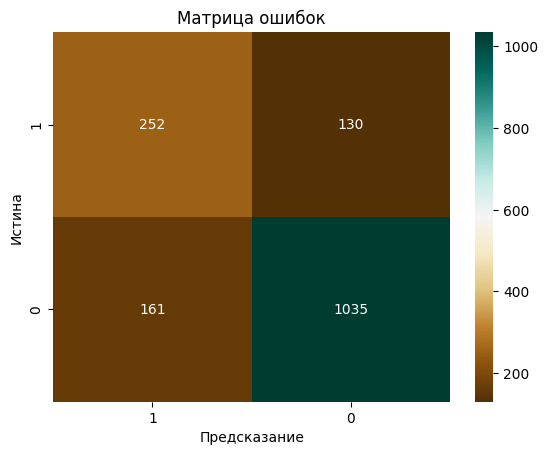

In [87]:
cm = confusion_matrix(y_valid, y_pred)

TN, FP, FN, TP = cm.ravel()

fp_fn_data = pd.DataFrame({
    '1': [TP, FN],
    '0': [FP, TN]
}, index=['1', '0'])

sns.heatmap(fp_fn_data, annot=True, fmt='d', cmap='BrBG', 
            xticklabels=['1', '0'], 
            yticklabels=['1', '0'])
plt.xlabel('Предсказание')
plt.ylabel('Истина')
plt.title('Матрица ошибок');

**True Positive (TP)**: Модель верно предсказала уход клиента (1 → 1).

**False Negative (FN)**: Модель пропустила уход (1 → 0) — **самая дорогая ошибка!**

**False Positive (FP)**: Модель ошибочно предупредила об уходе (0 → 1).

**True Negative (TN)**: Модель верно предсказала, что клиент остался (0 → 0).

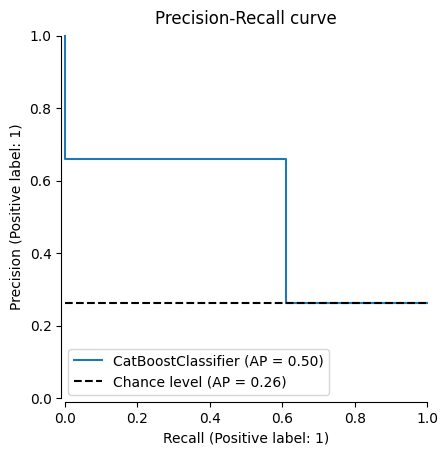

In [88]:
display = PrecisionRecallDisplay.from_predictions(
    y_valid, y_pred, name="CatBoostClassifier", plot_chance_level=True, despine=True
)
_ = display.ax_.set_title("Precision-Recall curve")

In [89]:
print(f"Precision (Ушел): {precision_score(y_valid, y_pred, pos_label=1):.2f}")
print(f"Recall (Ушел): {recall_score(y_valid, y_pred, pos_label=1):.2f}")
print(f"F1-Score (Ушел): {f1_score(y_valid, y_pred, pos_label=1):.2f}")

Precision (Ушел): 0.66
Recall (Ушел): 0.61
F1-Score (Ушел): 0.63


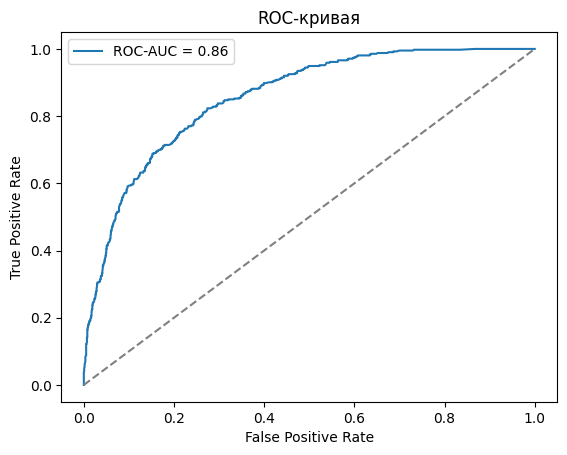

In [102]:
fpr, tpr, thresholds = roc_curve(y_valid, y_proba)
auc = roc_auc_score(y_valid, y_proba)

plt.plot(fpr, tpr, label=f'ROC-AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend();

Text(0.5, 1.0, 'Распределение вероятностей')

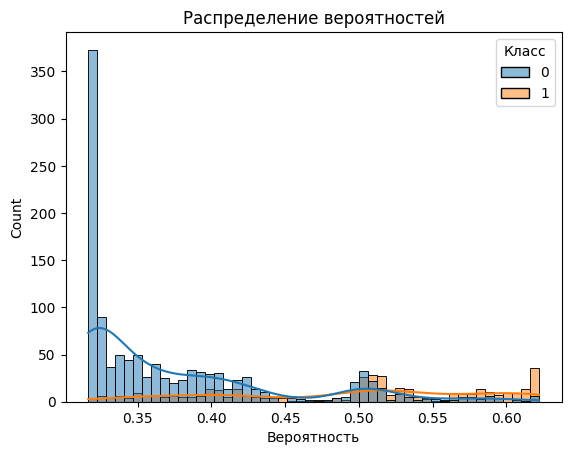

In [104]:
prob_df = pd.DataFrame({'Вероятность': y_proba, 'Класс': y_valid})
sns.histplot(data=prob_df, x='Вероятность', hue='Класс', bins=50, kde=True)
plt.title('Распределение вероятностей')

In [105]:
# delete temporary files
!rm -r catboost_info

"rm" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
